# Материалы

* [Презентация](https://disk.yandex.ru/d/BkVUivgsdArfig)
* [Дашборд](https://public.tableau.com/views/Book1_16532300107200/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)


# Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.


# План работы (Декомпозиция)
1. **Изучить файл с данными**:
 - Проверить данные на пропуски, дубликаты.
 - Визуализировать данные.
2. **Провести предобработку данных.**
3. **Провести исследовательский анализ:**
 - Изучить средние значения и стандартные отклонения
 - Проанализировать средние значения признаков в двух группах
 - Визуализация (гистограммы и распределения признаков (ушёл/остался))
 - Отобразить и построить матрицу корреляций
4. **Проверить статистические гипотезы:**
 - Различия дохода между теми клиентами, которые ушли и теми, которые остались
5. **Подготовка данных к машинному обучению:**
 - Перевод категориальных признаков в численные - One-Hot-Encoding.
 - Разбить данные на выборки: обучающую, тестовую.
6. **Обучить разные модели** (Древо решений, Случайный лес, CatBoost):
 - Выявить важные признаки.
 - Проанализировать скорость работы и качество моделей.
7. **Провести кластеризацию:**
 - Стандартизировать данные
 - Отрисовка дендрограммы
 - Обучите модель кластеризации (K-Means)
 - Проанализировать средние значения признаков для кластеров
8. **Выводы/Рекомендации**
9. **Подготовить презентацию**

## Ознакомление с данными

In [1]:
import pandas as pd
import numpy as np

from scipy import stats as st

from sklearn.preprocessing import StandardScaler
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from catboost import CatBoostClassifier

from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import silhouette_score


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/bank_dataset.csv')
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.columns = data.columns.str.lower()

In [4]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Индекс упорядочен:',data.index.is_monotonic)
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [5]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])

In [6]:
check(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
userid                 0
score                  0
city                   0
gender                 0
age 

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.0,1.573368e+07,71936.186123,15608437.00,1.567126e+07,1.573347e+07,1.579597e+07,15858426.00
score,10000.0,6.505288e+02,96.653299,350.00,5.840000e+02,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,3.200000e+01,3.700000e+01,4.400000e+01,92.00
objects,10000.0,5.012800e+00,2.892174,0.00,3.000000e+00,5.000000e+00,7.000000e+00,10.00
balance,6383.0,1.198275e+05,30095.056462,3768.69,1.001820e+05,1.198397e+05,1.395123e+05,250898.09
products,10000.0,1.530200e+00,0.581654,1.00,1.000000e+00,1.000000e+00,2.000000e+00,4.00
creditcard,10000.0,7.055000e-01,0.455840,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
loyalty,10000.0,5.151000e-01,0.499797,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,5.100211e+04,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.00


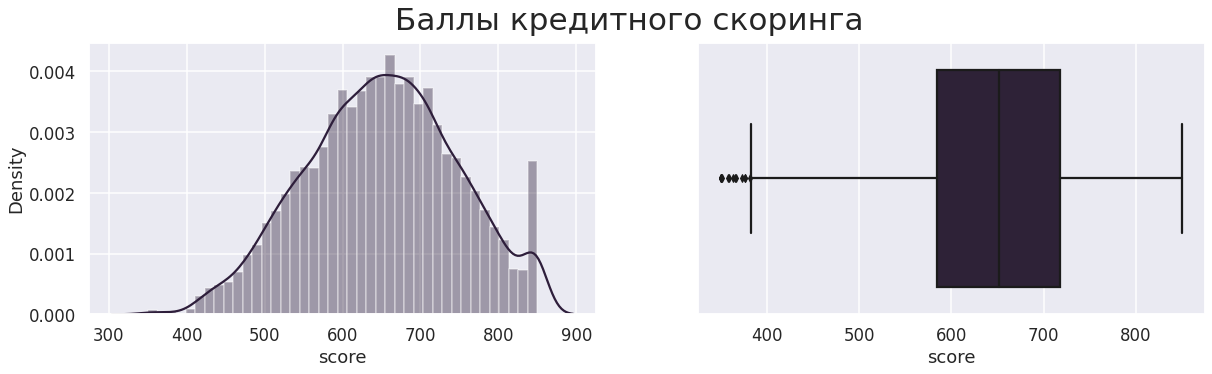

In [10]:
charts(data, 'score', 'Баллы кредитного скоринга')

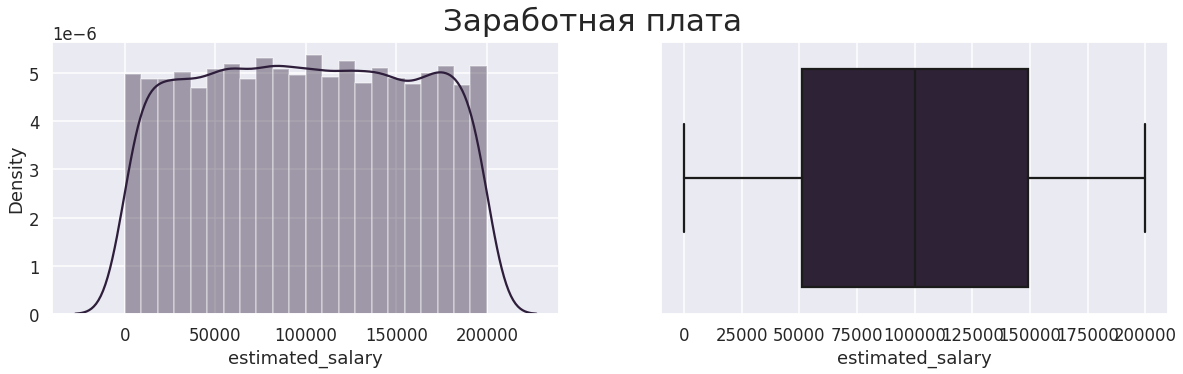

In [11]:
charts(data, 'estimated_salary', 'Заработная плата')

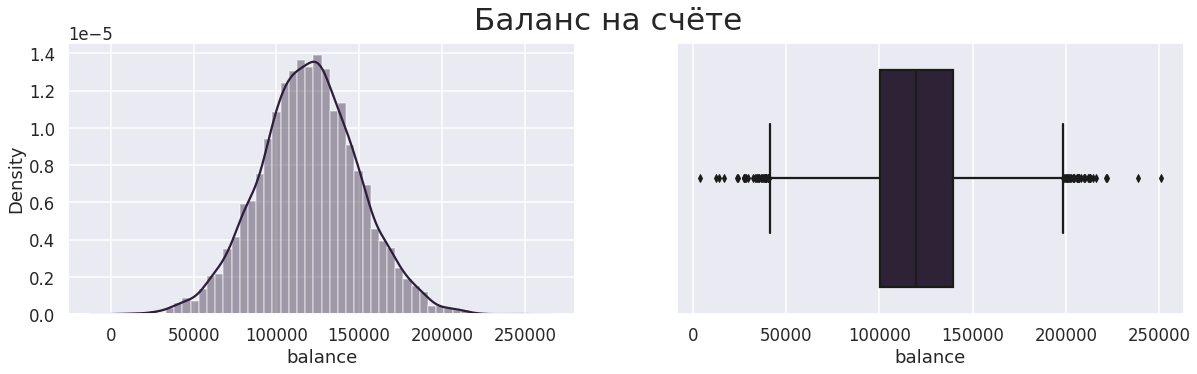

In [12]:
charts(data, 'balance', 'Баланс на счёте')

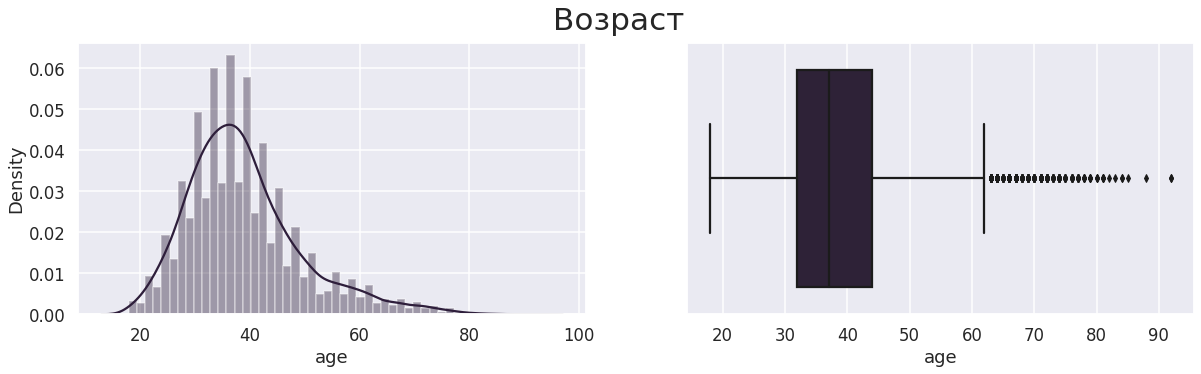

In [13]:
charts(data, 'age', 'Возраст')

**Промежуточные выводы:** Наш датасет с данным о 10 000 клиентов банка, который располагается в Ярославле и областных городах: Ростов Великий. Возраст клиентов от 18 до 92 лет.  Имеются пропуски в столбце Balance (Баланс) — составляет 36% пропусков. Дубликаты отсутствуют. Будем иметь явный дисбаланс в данных. Пустые значения можем заполнить либо нулями (правда это приведет к большим выбросам), либо медианами.

## Предобработка данных

### Пропуски

In [14]:
data[data['balance'].isna()].groupby(['city','creditcard'])['userid'].count().reset_index()

,city,creditcard,userid
0,Рыбинск,0,347
1,Рыбинск,1,852
2,Ярославль,0,678
3,Ярославль,1,1740


In [15]:
print('Total nan:', data['balance'].isna().sum())

print('')
print('Ростов Великий nan count:', data[data['city'] == 'Ростов Великий']['balance'].isna().sum())

print('Рыбинск nan count:', data[data['city'] == 'Рыбинск']['balance'].isna().sum())

print('Ярославль nan count:', data[data['city'] == 'Ярославль']['balance'].isna().sum())

print()
print('Creditcard - no:',data[data['creditcard'] == 0]['balance'].isna().sum())
print('Creditcard - yes:',data[data['creditcard'] == 1]['balance'].isna().sum())

Total nan: 3617

Ростов Великий nan count: 0
Рыбинск nan count: 1199
Ярославль nan count: 2418

Creditcard - no: 1025
Creditcard - yes: 2592


In [16]:
nan_data = data[data['balance'].isnull()]

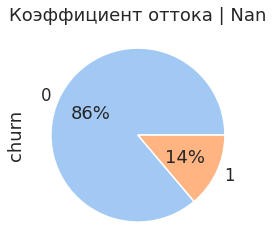

In [17]:
colors = sns.color_palette('pastel')[0:5]

nan_data['churn'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Коэффициент оттока | Nan')
plt.show()

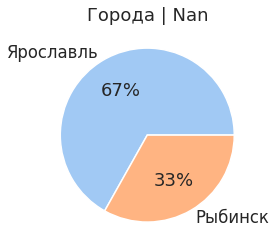

In [18]:
nan_data['city'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Города | Nan')
plt.ylabel('')
plt.show()

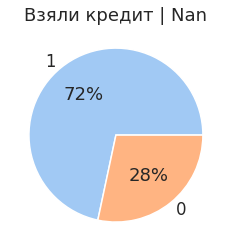

In [19]:
nan_data['creditcard'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Взяли кредит | Nan')
plt.ylabel('')
plt.show()

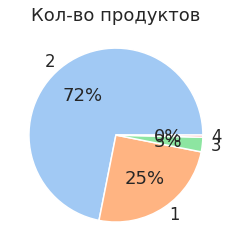

In [20]:
nan_data['products'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Кол-во продуктов')
plt.ylabel('')
plt.show()

**Промежуточные выводы:** Всего пропусков в стобце баланс 3617. Видим, что пропуски в данных имеются только в двух городах Ярославль и Рыбинск. Также, стоит заметить, что 70% пропусков у клиентов, у которых имеются кредитные карты. Коэффициент оттока в данных, где есть пропуски в балансе - 14%. Предположительно, пропуски это нуливые значения, возможно, кто-то только открывает счет и не успел его пополнить, а кто-то наоброт его закрывает. Также, может быть, общий отток у нас 2000 клиентов, и 1617 это новые клиенты, которые только открыли счет или оформили кредит без открытия дебетового счета. Заполним пропуски нулями.

In [21]:
data['balance'] = data['balance'].fillna(0.0)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


## Исследовательский анализ

In [22]:
data.groupby('churn').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,1.573279e+07,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


**Промежуточные выводы:** Видим, явные отличия в двух столбцах - Возраст и Лояльность. Оттоку подвержены более возрастная группа и также они менее лояльны. В данном контексте, под лояльностью подразумевается, что клиенты меньше взаимодесвуют с услугами банка (меньше производят транзакций, меньше зачислений).

In [23]:
def age_category(age):
    if age <=30:
        return 'молодые'
    elif age > 30 and age <= 55:
        return 'взрослые'
    else:
        return 'пенсионеры'
    
data['age_category'] = data['age'].apply(age_category)
data['age_category'].value_counts()

взрослые      7232
молодые       1968
пенсионеры     800
Name: age_category, dtype: int64

In [24]:
data.groupby(['city','age_category']).mean()

userid       score        age   objects  \
city           age_category                                                  
Ростов Великий взрослые      1.573382e+07  651.931670  40.316161  5.034165   
               молодые       1.573185e+07  651.598234  26.671082  4.911700   
               пенсионеры    1.573178e+07  646.985849  63.028302  5.009434   
Рыбинск        взрослые      1.573402e+07  651.223398  39.445125  4.992201   
               молодые       1.573439e+07  647.431866  26.410901  5.301887   
               пенсионеры    1.574082e+07  661.380488  63.078049  4.756098   
Ярославль      взрослые      1.573410e+07  648.670470  39.224325  5.000278   
               молодые       1.573018e+07  652.759152  26.660886  5.046243   
               пенсионеры    1.573535e+07  650.652742  63.945170  4.932115   

                                   balance  products  creditcard   loyalty  \
city           age_category                                                  
Ростов Великий взрослые      119732.469572  1.529284    0.709870  0.481020   
               молодые       119186.954062  1.503311    0.735099  0.509934   
               пенсионеры    120870.270283  1.471698    0.702830  0.613208   
Рыбинск        взрослые       62030.913783  1.528134    0.688579  0.501393   
               молодые        59047.309958  1.601677    0.702306  0.517820   
               пенсионеры     66402.414244  1.492683    0.731707  0.804878   
Ярославль      взрослые       62970.030019  1.523518    0.707487  0.492346   
               молодые        59631.898468  1.556840    0.705202  0.508671   
               пенсионеры     60530.681514  1.530026    0.702350  0.767624   

                             estimated_salary     churn  
city           age_category                              
Ростов Великий взрослые         102240.540157  0.350325  
               молодые           98452.036137  0.123620  
               пенсионеры        96996.604953  0.528302  
Рыбинск        взрослые          99719.170724  0.174930  
               молодые           99020.332474  0.085954  
               пенсионеры        97978.963415  0.282927  
Ярославль      взрослые          99488.604887  0.176733  
               молодые          103192.340039  0.049133  
               пенсионеры        94825.812742  0.323760

**Промежуточные выводы:** Видим, что во всех трех городах пенсионеры больше всего склонны уходить (28%, 32%, 52%). А молодежь наоборот имеет наименьший процент оттока (3%, 8%, 12%). Взрослая группа имеет отток (17%, 17%, 35%). Во всех возрастных группах самые высокие оттоки в Ростове Великом.

In [25]:
def income_category (estimated_salary):
    if estimated_salary <= 50000:
        return 'низкий'
    elif estimated_salary > 50000 and estimated_salary <= 110000:
        return 'средний'
    elif estimated_salary > 110000 and estimated_salary <= 170000:
        return 'выше среднего'
    elif estimated_salary > 170000 and estimated_salary <= 200000:
        return 'высокий'
    else:
        return 'очень высокий'
    
data['income_category'] = data['estimated_salary'].apply(income_category)
data['income_category'].value_counts()

средний          3073
выше среднего    2958
низкий           2453
высокий          1516
Name: income_category, dtype: int64

In [26]:
data.groupby(['city','income_category']).mean()

userid       score        age   objects  \
city           income_category                                                  
Ростов Великий высокий          1.573352e+07  655.067146  39.990408  5.151079   
               выше среднего    1.573279e+07  646.725627  39.160167  5.115599   
               низкий           1.573261e+07  652.191558  40.012987  4.879870   
               средний          1.573419e+07  653.344327  40.034301  4.937995   
Рыбинск        высокий          1.573857e+07  653.820000  39.905714  4.865714   
               выше среднего    1.573474e+07  647.544021  38.515112  5.176084   
               низкий           1.573096e+07  657.382114  38.879675  4.900813   
               средний          1.573577e+07  649.062583  38.808256  5.071904   
Ярославль      высокий          1.573708e+07  656.445928  37.985314  4.986649   
               выше среднего    1.573337e+07  647.796484  38.440162  4.979040   
               низкий           1.573126e+07  650.547463  38.293781  5.067103   
               средний          1.573329e+07  647.505754  39.001918  4.988491   

                                      balance  products  creditcard   loyalty  \
city           income_category                                                  
Ростов Великий высокий          119666.282350  1.503597    0.719424  0.484412   
               выше среднего    119324.736058  1.525070    0.717270  0.500000   
               низкий           118928.925698  1.498377    0.704545  0.503247   
               средний          120800.320475  1.540897    0.715040  0.497361   
Рыбинск        высокий           59057.577914  1.568571    0.691429  0.554286   
               выше среднего     65216.552681  1.512484    0.685940  0.524310   
               низкий            60781.754715  1.536585    0.728455  0.544715   
               средний           60509.752330  1.555260    0.677763  0.511318   
Ярославль      высокий           63109.272884  1.570093    0.696929  0.487316   
               выше среднего     62189.141968  1.525355    0.694388  0.521298   
               низкий            60588.783969  1.514730    0.707038  0.513093   
               средний           62689.513504  1.530051    0.722506  0.529412   

                                estimated_salary     churn  
city           income_category                              
Ростов Великий высокий             184989.916067  0.306954  
               выше среднего       139830.402465  0.320334  
               низкий               25208.101347  0.357143  
               средний              79982.050488  0.311346  
Рыбинск        высокий             184986.509543  0.174286  
               выше среднего       139262.263982  0.183968  
               низкий               24621.245382  0.149593  
               средний              80490.506525  0.159787  
Ярославль      высокий             184762.549266  0.186916  
               выше среднего       139946.669527  0.162272  
               низкий               24937.302553  0.144845  
               средний              79957.055786  0.161765

**Промежуточные выводы:** По сегментам заработка видим, примерно, такаю же картину - среди трех городов больше всего отток у Ростова Великого, по сегментам заработка от 30 до 35%. У Рыбинска и Ярославля примерно похожая ситуация - отток от 15 до 18%.

In [27]:
def score_category(score):
    if score <= 500:
        return 'очень низкий'
    elif score > 500 and score <= 580:
        return 'низкий'
    elif score > 580 and score <= 680:
        return 'средний'
    elif score > 680 and score <= 780:
        return 'высокий'
    else:
        return 'очень высокий'
    
data['score_category'] = data['score'].apply(score_category)
data['score_category'].value_counts()

средний          3732
высокий          2925
низкий           1750
очень высокий     950
очень низкий      643
Name: score_category, dtype: int64

In [28]:
data.groupby('score_category').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
score_category,,,,,,,,,,
высокий,1.573375e+07,723.916239,38.875897,5.014017,77047.888400,1.538803,0.702564,0.526838,100086.365573,0.195214
низкий,1.573276e+07,544.484000,38.821143,4.952000,74801.036377,1.502857,0.685143,0.503429,99569.623446,0.216000
очень высокий,1.573468e+07,818.465263,38.922105,5.038947,76358.787000,1.536842,0.697895,0.522105,101947.790979,0.196842
очень низкий,1.573415e+07,463.559876,38.950233,5.074650,80241.272053,1.517885,0.726283,0.468118,103690.177994,0.236392
средний,1.573371e+07,632.201233,39.000000,5.023044,76220.798518,1.536710,0.715702,0.517685,99244.306699,0.200697


In [29]:
data.groupby('city').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
city,,,,,,,,,,
Ростов Великий,1.573329e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Рыбинск,1.573465e+07,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734
Ярославль,1.573339e+07,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548


### Графики

In [30]:
x = data.copy()

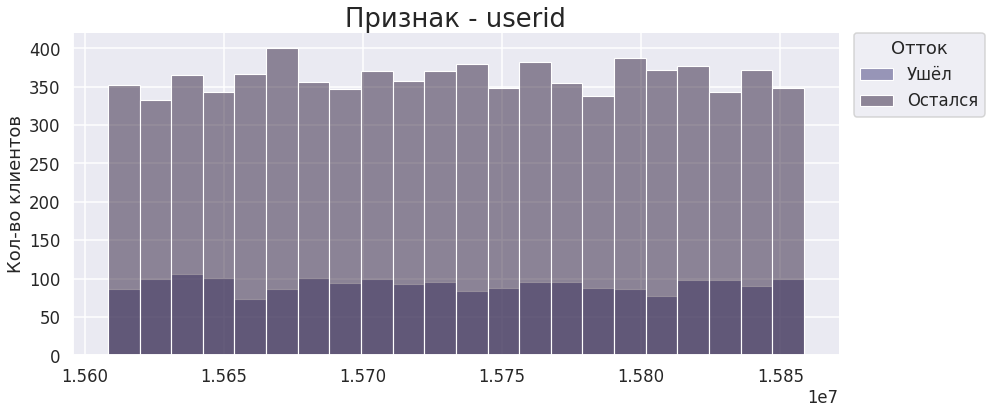

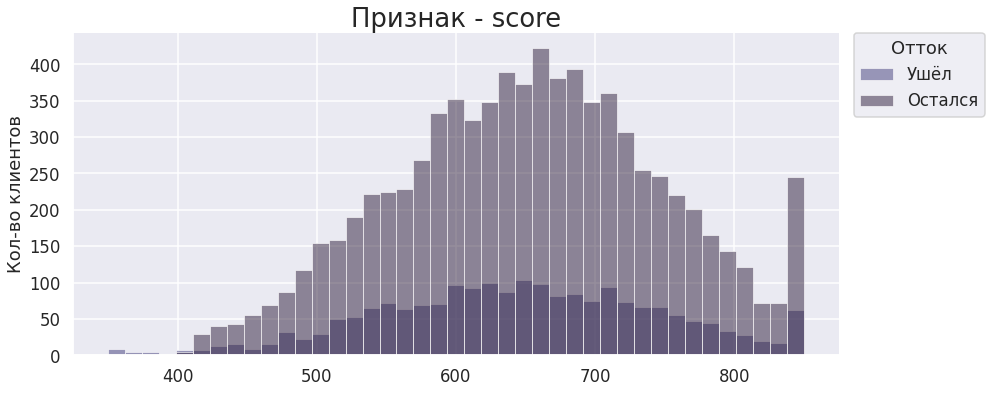

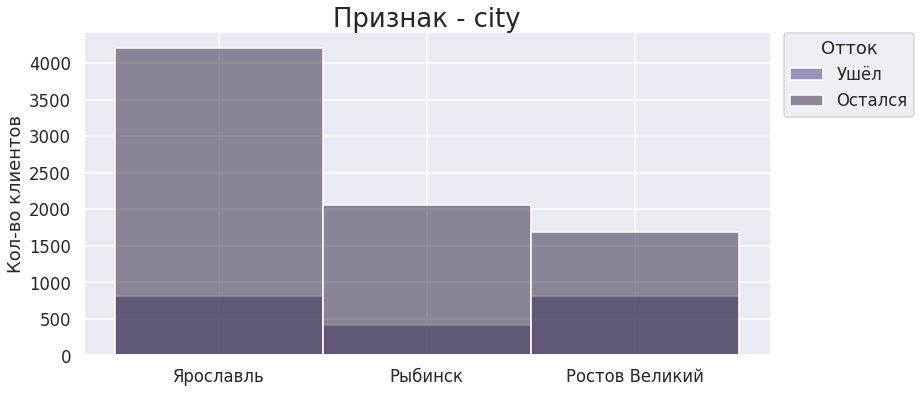

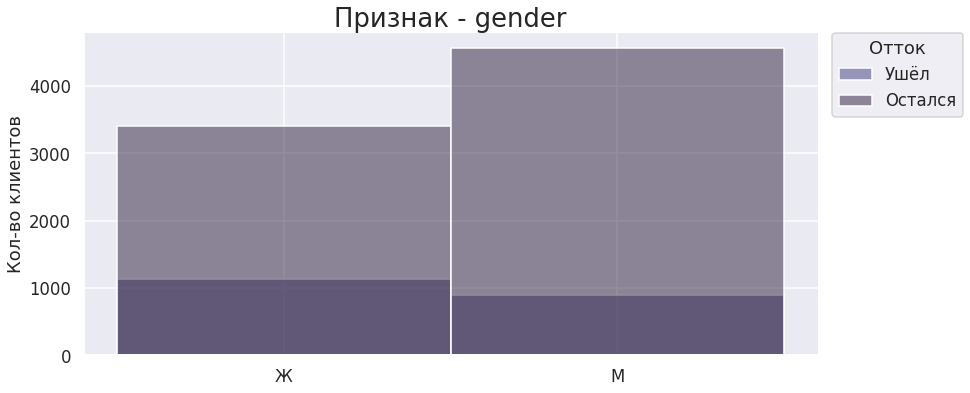

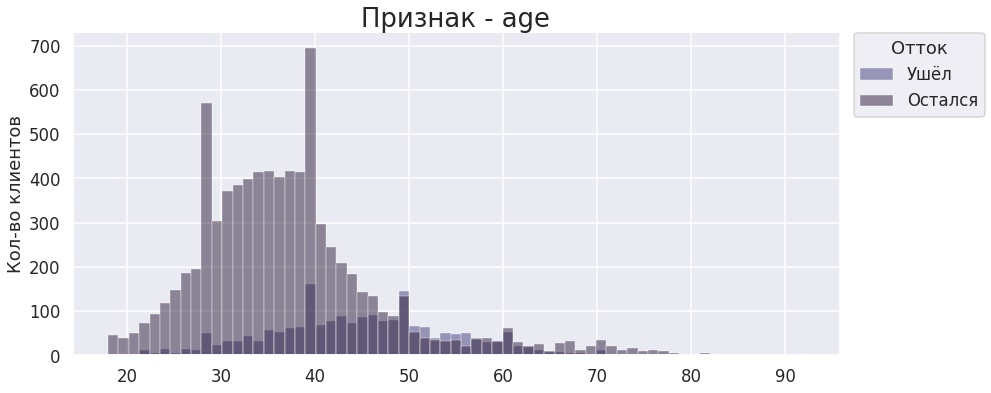

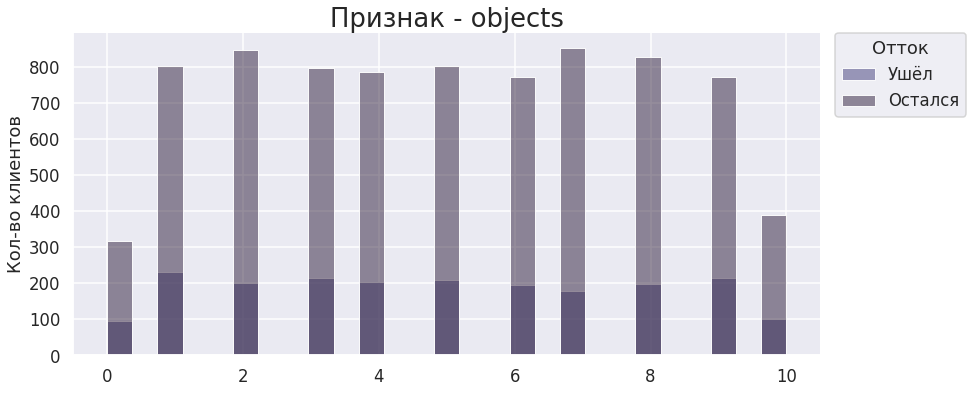

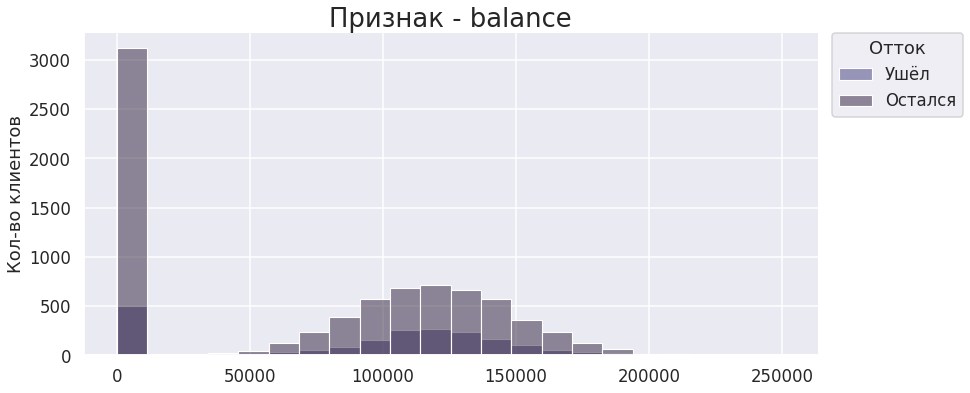

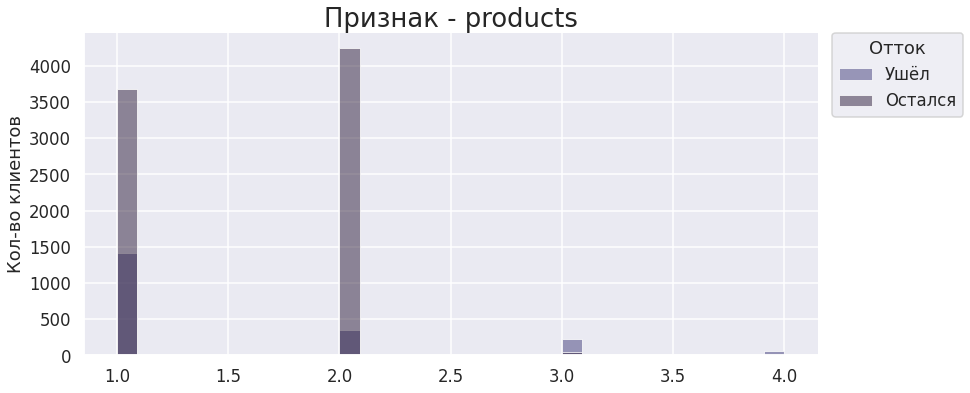

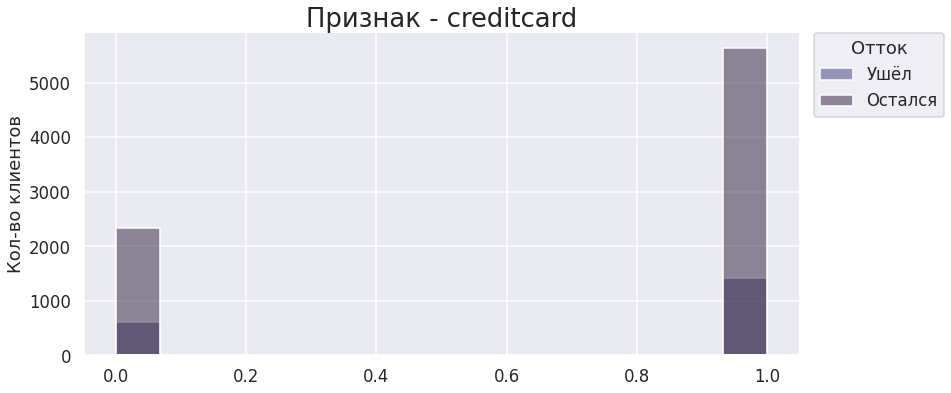

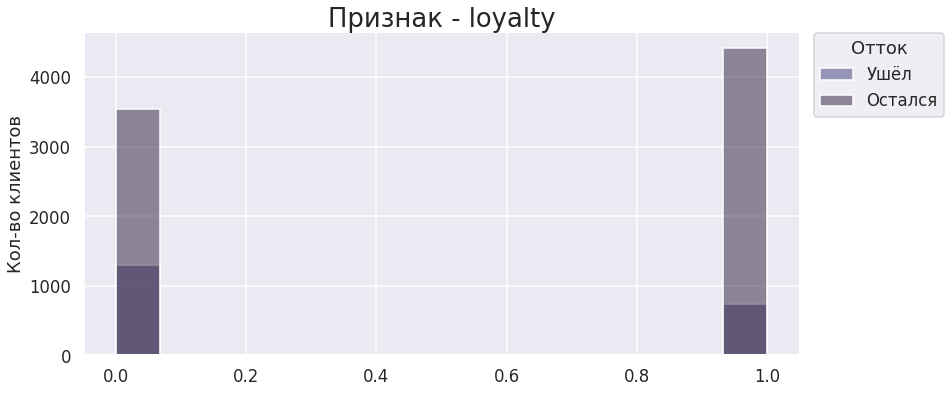

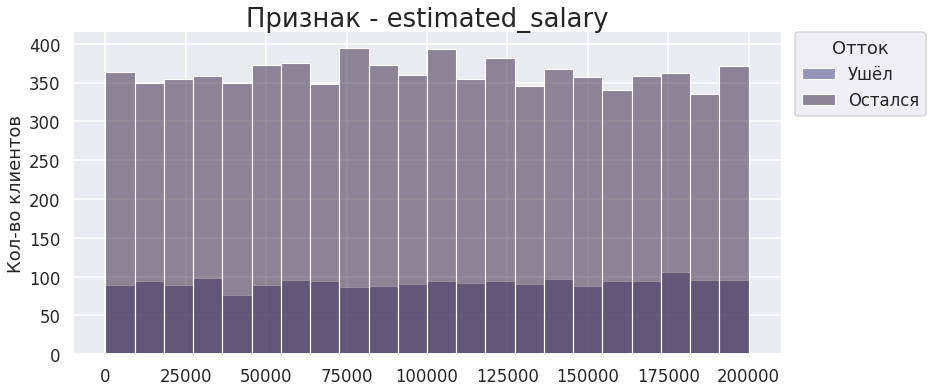

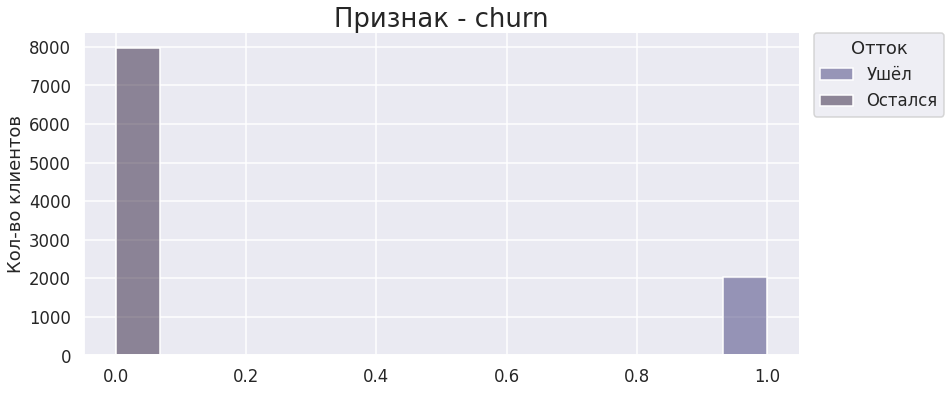

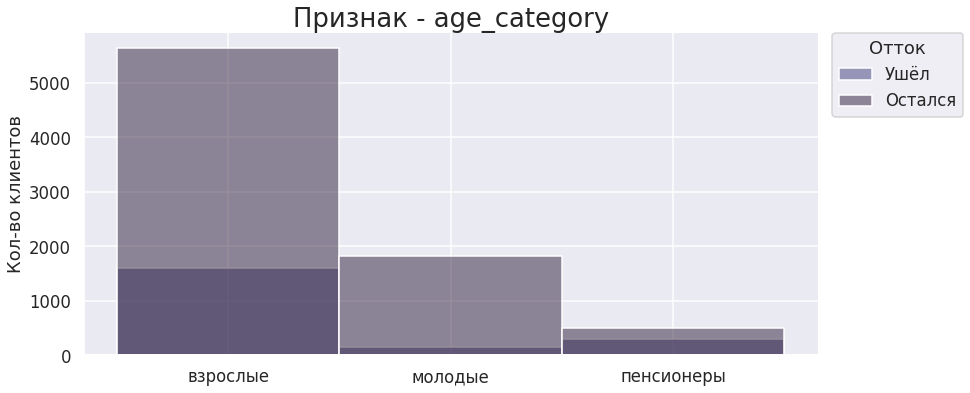

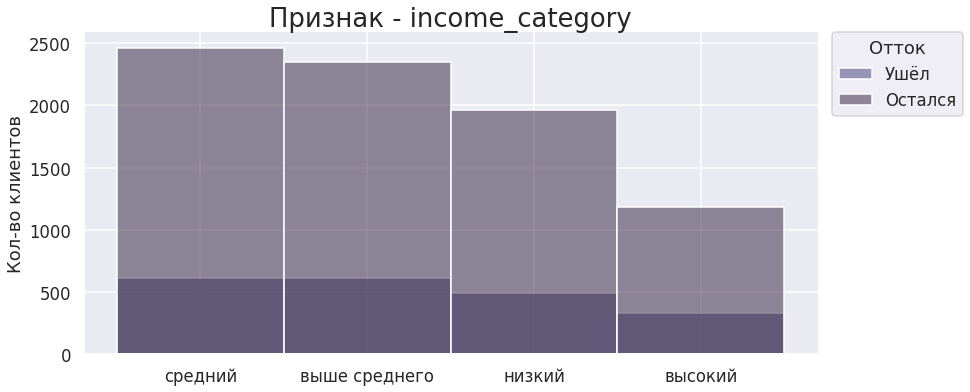

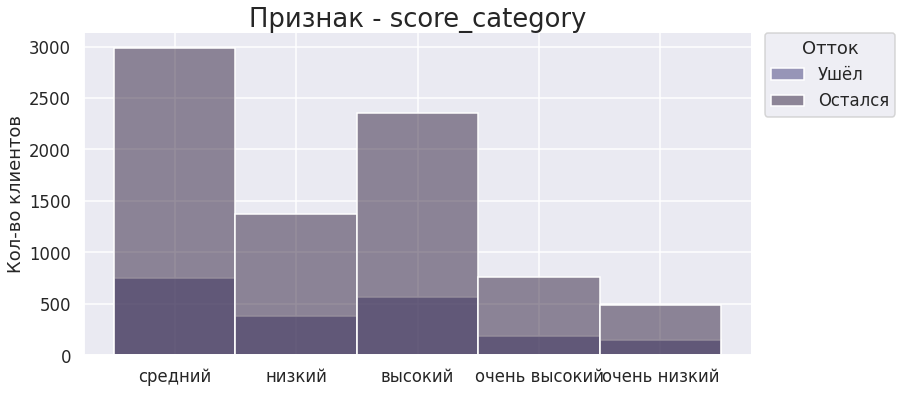

In [31]:
for i in x:
    dis = sns.displot(data, x=data[i], hue='churn', kind='hist', legend = False)
    plt.title('Признак - {}'.format(i), fontsize= 'x-large')
    plt.ylabel('Кол-во клиентов')
    plt.xlabel('')
    plt.legend(title='Отток', bbox_to_anchor=(1.02, 1),borderaxespad=0, loc='upper left', labels=['Ушёл', 'Остался'])
    dis.fig.set_figwidth(15)
    dis.fig.set_figheight(6)
    dis.fig.patch.set_linewidth(5)

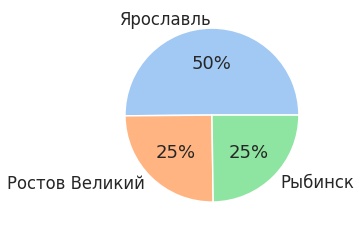

In [32]:
data['city'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('')
plt.ylabel('')
plt.show()

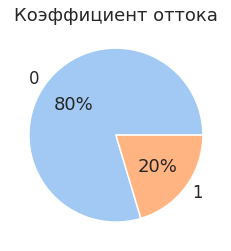

In [33]:
data['churn'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Коэффициент оттока')
plt.ylabel('')
plt.show()

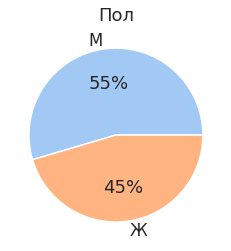

In [34]:
data['gender'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Пол')
plt.ylabel('')
plt.show()

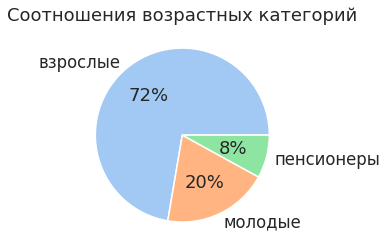

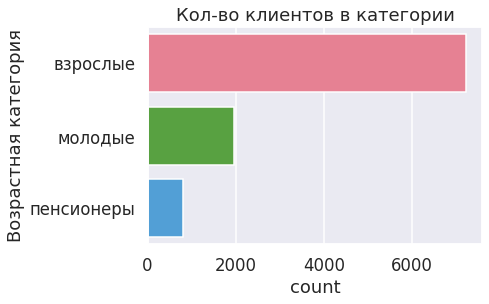

In [35]:
data['age_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения возрастных категорий')
plt.ylabel('')
plt.show()
sns.countplot(y='age_category', data=data, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Возрастная категория')
plt.show()

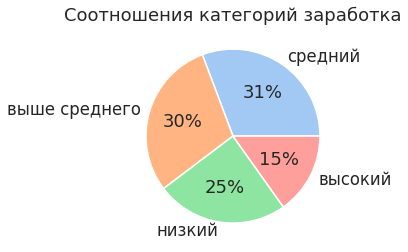

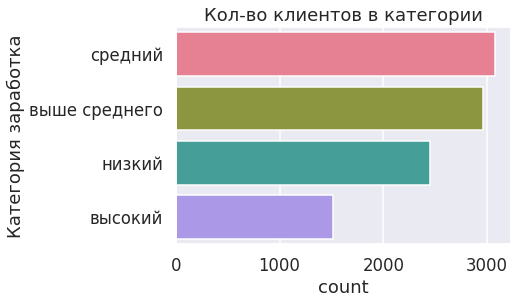

In [36]:
data['income_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения категорий заработка')
plt.ylabel('')
plt.show()
sns.countplot(y='income_category', data=data, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Категория заработка')
plt.show()

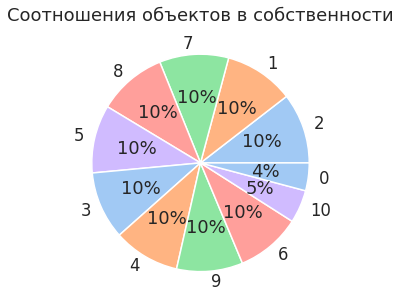

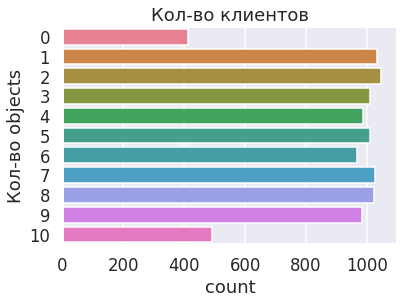

In [37]:
plt.figure(figsize=(12,5))
data['objects'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения объектов в собственности')
plt.ylabel('')
plt.show()
sns.countplot(y='objects', data=data, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во objects')
plt.show()

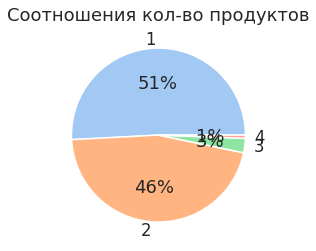

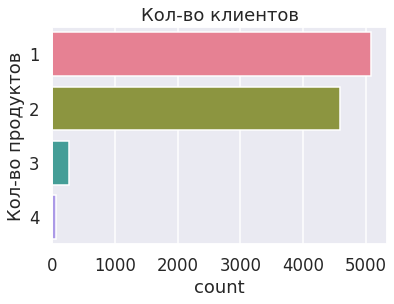

In [38]:
data['products'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения кол-во продуктов')
plt.ylabel('')
plt.show()
sns.countplot(y='products', data=data, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во продуктов')
plt.show()

In [39]:
data.groupby('products').mean()

,userid,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
products,,,,,,,,,
1,1.573237e+07,649.120968,39.673092,4.974626,98551.870614,0.703777,0.504131,99487.256851,0.277144
2,1.573484e+07,652.188671,37.753595,5.051852,51879.145813,0.707190,0.532898,100452.012821,0.075817
3,1.574182e+07,648.105263,43.195489,5.003759,75458.328195,0.714286,0.424812,104318.130564,0.827068
4,1.571936e+07,653.583333,45.683333,5.300000,93733.135000,0.683333,0.483333,104763.723333,1.000000


In [40]:
print('Кол-во клиентов с 3-мя продуктами:',data[data['products'] == 3].shape[0])
print('Кол-во клиентов с 4-мя продуктами:',data[data['products'] > 3].shape[0])

Кол-во клиентов с 3-мя продуктами: 266
Кол-во клиентов с 4-мя продуктами: 60


In [41]:
data.groupby(['products','city']).mean()

userid       score        age   objects  \
products city                                                            
1        Ростов Великий  1.573196e+07  651.402520  40.572276  5.005189   
         Рыбинск         1.573298e+07  648.929566  39.704341  4.965602   
         Ярославль       1.573229e+07  647.989658  39.175418  4.962609   
2        Ростов Великий  1.573432e+07  651.543269  38.267308  5.025000   
         Рыбинск         1.573629e+07  654.097210  37.901944  5.114962   
         Ярославль       1.573435e+07  651.518378  37.453739  5.032108   
3        Ростов Великий  1.574546e+07  653.718750  43.656250  5.010417   
         Рыбинск         1.573976e+07  647.015152  40.909091  4.803030   
         Ярославль       1.573976e+07  643.615385  44.221154  5.125000   
4        Ростов Великий  1.571482e+07  641.375000  44.416667  4.625000   
         Рыбинск         1.570222e+07  644.428571  45.142857  4.857143   
         Ярославль       1.572726e+07  665.896552  46.862069  5.965517   

                               balance  creditcard   loyalty  \
products city                                                  
1        Ростов Великий  119868.328139    0.705708  0.466271   
         Рыбинск          90595.373063    0.688780  0.551188   
         Ярославль        90977.877896    0.710024  0.501591   
2        Ростов Великий  119341.245038    0.720192  0.546154   
         Рыбинск          32690.852688    0.704987  0.514793   
         Ярославль        31828.097047    0.702577  0.536122   
3        Ростов Великий  121572.672396    0.750000  0.427083   
         Рыбинск          48385.897121    0.590909  0.424242   
         Ярославль        50071.822500    0.759615  0.423077   
4        Ростов Великий  121442.305417    0.750000  0.416667   
         Рыбинск          91407.651429    1.000000  0.285714   
         Ярославль        71362.731379    0.551724  0.586207   

                         estimated_salary     churn  
products city                                        
1        Ростов Великий     101029.034136  0.428466  
         Рыбинск             99280.483112  0.218673  
         Ярославль           98760.372673  0.224344  
2        Ростов Великий     100832.057606  0.121154  
         Рыбинск             99525.563609  0.073542  
         Ярославль          100748.059649  0.057034  
3        Ростов Великий     106681.521667  0.895833  
         Рыбинск            103223.656970  0.787879  
         Ярославль          102831.108558  0.788462  
4        Ростов Великий      95778.151250  1.000000  
         Рыбинск             77332.078571  1.000000  
         Ярославль          118821.490345  1.000000

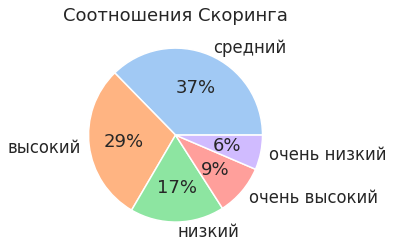

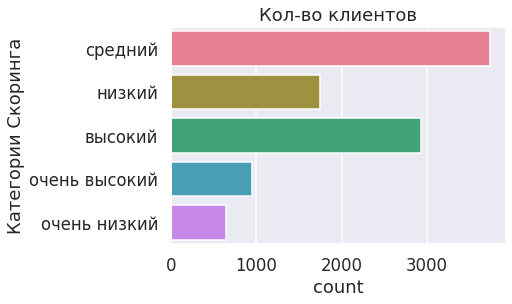

In [42]:
data['score_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения Скоринга')
plt.ylabel('')
plt.show()
sns.countplot(y='score_category', data=data, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Категории Скоринга')
plt.show()

In [43]:
data.groupby('score_category').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
score_category,,,,,,,,,,
высокий,1.573375e+07,723.916239,38.875897,5.014017,77047.888400,1.538803,0.702564,0.526838,100086.365573,0.195214
низкий,1.573276e+07,544.484000,38.821143,4.952000,74801.036377,1.502857,0.685143,0.503429,99569.623446,0.216000
очень высокий,1.573468e+07,818.465263,38.922105,5.038947,76358.787000,1.536842,0.697895,0.522105,101947.790979,0.196842
очень низкий,1.573415e+07,463.559876,38.950233,5.074650,80241.272053,1.517885,0.726283,0.468118,103690.177994,0.236392
средний,1.573371e+07,632.201233,39.000000,5.023044,76220.798518,1.536710,0.715702,0.517685,99244.306699,0.200697


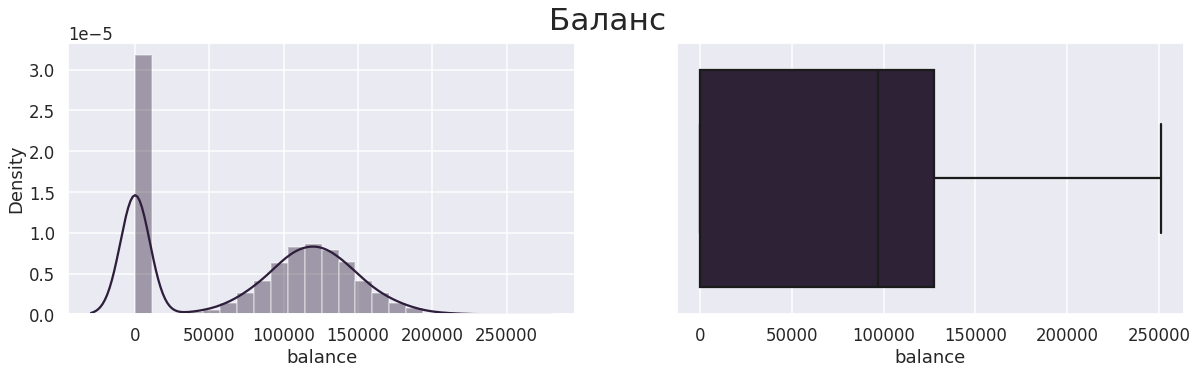

In [44]:
sns.set(palette='mako', context='talk',style='darkgrid')

charts(data, 'balance', 'Баланс')

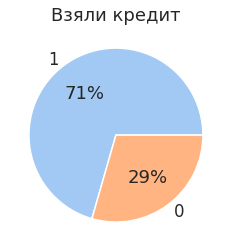

In [45]:
data['creditcard'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Взяли кредит')
plt.ylabel('')
plt.show()

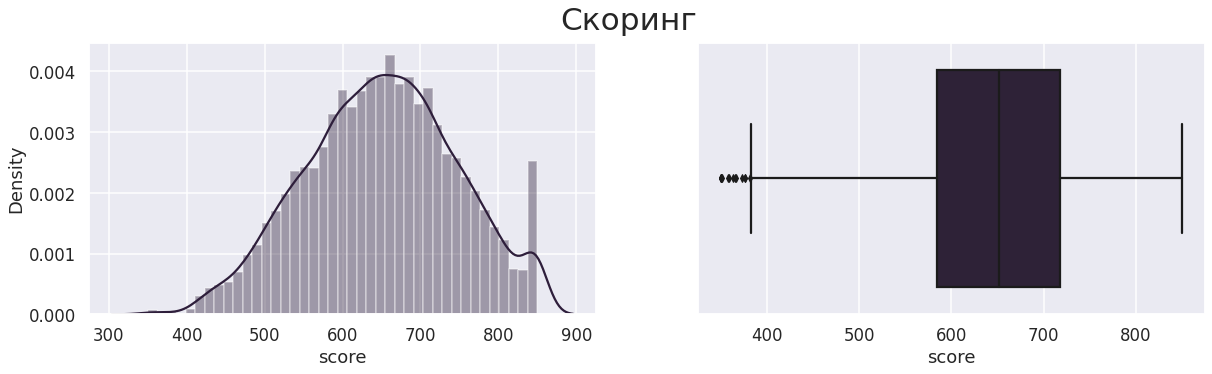

In [46]:
charts(data, 'score', 'Скоринг')

**Промежуточные выводы:** 
- У нас данные по городам деляться в следующей пропорции: 50% Ярославль и по 25% Рыбинск и Ростов великий.
- Мужчин на 10% больше, чем женщин.
- 60% клиентов имеют заработную плату от 50 тыс. до 170 тыс.
- Всего 5% клиентов не имеют или не указало данных о собственности имущества.
- Большинство 97% пользуется 1-2 продуктами банка, 3 продуктами - 3%, а 4 - 1%. Видим, что клиенты которые пользуются 3-4 продуктами (всего их - 326 чел.), во-первых, старше, средний возраст 43-45, а во-вторых склонны больше всех уходить. Все (60 чел.) те, кто пользовались 4 услугами/продуктами банка ушли. 82% клиентов у кого числиться использования 3-х продуктов тоже отвалились. Самый низкий процент оттока у клиентов, которые пользуются двумя продуктами.
- Самый высокий процент отток со скорингом до 500 - 23%. Самый низкий процент отток со скорингом от 680 - 19%. Средняя категория от 500 до 680 составляет - 20%

Вырисовываются предположительные портреты:
- Нежелательные клиенты: М/Ж от 40 лет, имеющие скоринг ниже 650, пользующиеся 3-4 услугами.
- Желательные клиенты: М/Ж до 40 лет, имеющие скоринг выше 650, использующие 1-2 продукта.

### Города

#### Рыбинск

In [50]:
rybinsk = data[data['city'] == 'Рыбинск']

In [51]:
rybinsk.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,2477.0,1.573465e+07,71765.540066,15608437.00,15672281.00,15734528.00,15796490.00,15858426.00
score,2477.0,6.513339e+02,94.365051,350.00,587.00,651.00,715.00,850.00
age,2477.0,3.889100e+01,10.446119,18.00,32.00,37.00,44.00,88.00
objects,2477.0,5.032297e+00,2.856660,0.00,3.00,5.00,8.00,10.00
balance,2477.0,6.181815e+04,64235.555208,0.00,0.00,61710.44,121056.63,250898.09
products,2477.0,1.539362e+00,0.564646,1.00,1.00,2.00,2.00,4.00
creditcard,2477.0,6.947921e-01,0.460588,0.00,0.00,1.00,1.00,1.00
loyalty,2477.0,5.296730e-01,0.499220,0.00,0.00,1.00,1.00,1.00
estimated_salary,2477.0,9.944057e+04,57103.678091,417.41,50267.69,99984.86,147278.43,199992.48
churn,2477.0,1.667340e-01,0.372813,0.00,0.00,0.00,0.00,1.00


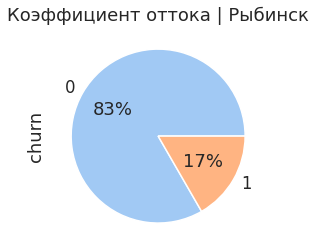

In [52]:
rybinsk['churn'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Коэффициент оттока | Рыбинск')
plt.show()

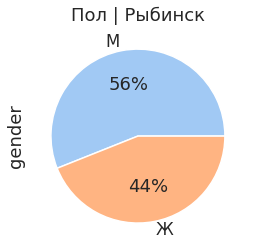

In [53]:
rybinsk['gender'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Пол | Рыбинск')
plt.show()

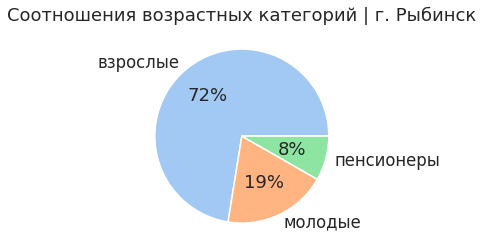

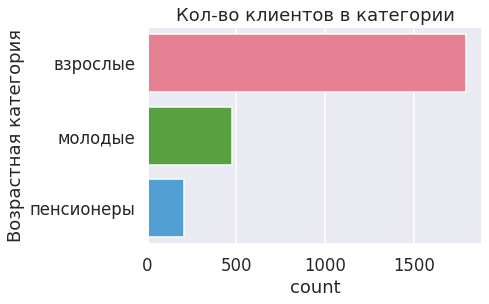

In [54]:
rybinsk['age_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения возрастных категорий | г. Рыбинск')
plt.ylabel('')
plt.show()
sns.countplot(y='age_category', data=rybinsk, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Возрастная категория')
plt.show()

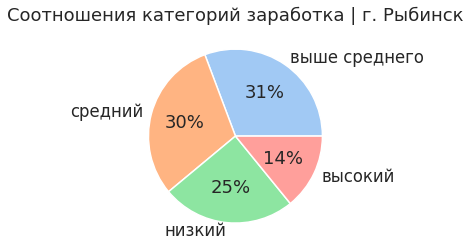

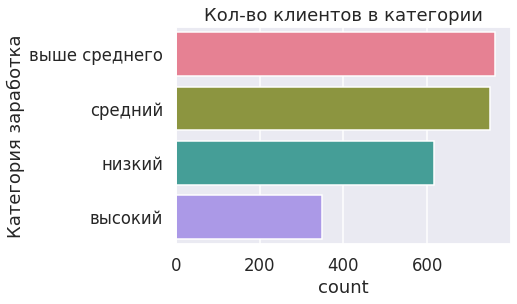

In [55]:
rybinsk['income_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения категорий заработка | г. Рыбинск')
plt.ylabel('')
plt.show()
sns.countplot(y='income_category', data=rybinsk, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Категория заработка')
plt.show()

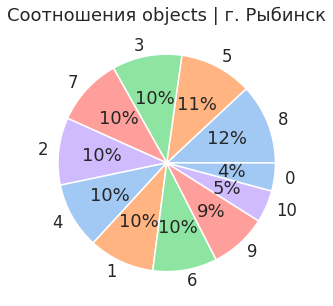

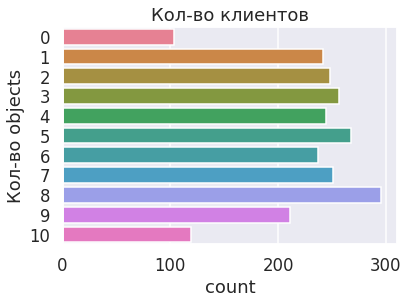

In [56]:
plt.figure(figsize=(12,5))
rybinsk['objects'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения objects | г. Рыбинск')
plt.ylabel('')
plt.show()
sns.countplot(y='objects', data=rybinsk, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во objects')
plt.show()

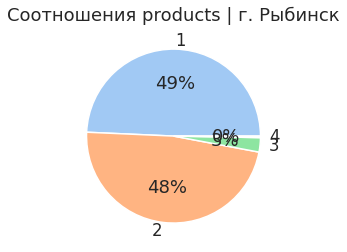

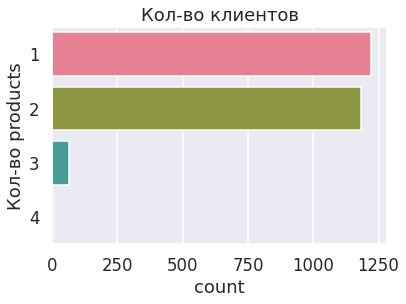

In [57]:
rybinsk['products'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения products | г. Рыбинск')
plt.ylabel('')
plt.show()
sns.countplot(y='products', data=rybinsk, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во products')
plt.show()

In [58]:
rybinsk.groupby('products').mean()

,userid,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
products,,,,,,,,,
1,1.573298e+07,648.929566,39.704341,4.965602,90595.373063,0.688780,0.551188,99280.483112,0.218673
2,1.573629e+07,654.097210,37.901944,5.114962,32690.852688,0.704987,0.514793,99525.563609,0.073542
3,1.573976e+07,647.015152,40.909091,4.803030,48385.897121,0.590909,0.424242,103223.656970,0.787879
4,1.570222e+07,644.428571,45.142857,4.857143,91407.651429,1.000000,0.285714,77332.078571,1.000000


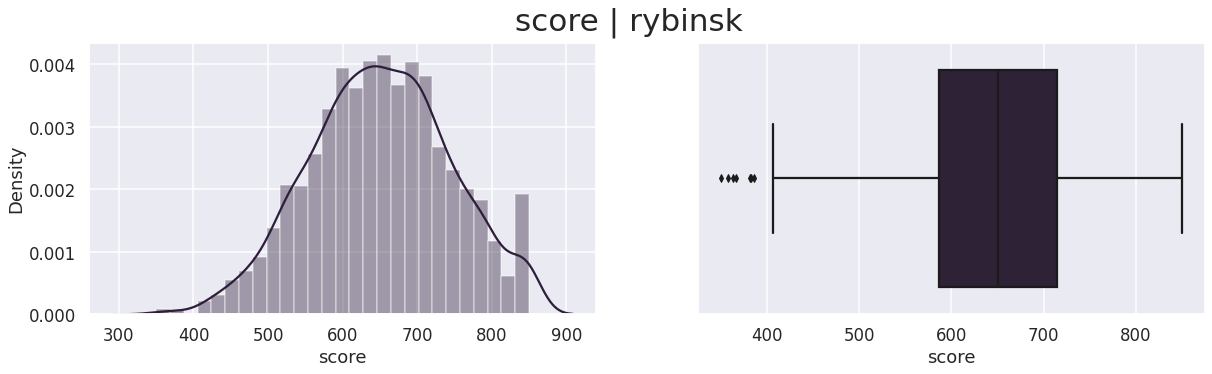

In [59]:
charts(rybinsk, 'score', 'score | rybinsk')

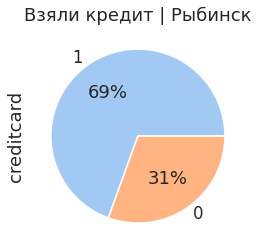

In [60]:
rybinsk['creditcard'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Взяли кредит | Рыбинск')
plt.show()

In [61]:
rybinsk.groupby('churn').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573550e+07,652.104167,37.839147,5.107558,59678.070470,1.544574,0.699128,0.567345,98602.369864
1,1.573042e+07,647.484262,44.147700,4.656174,72513.352446,1.513317,0.673123,0.341404,103629.554818


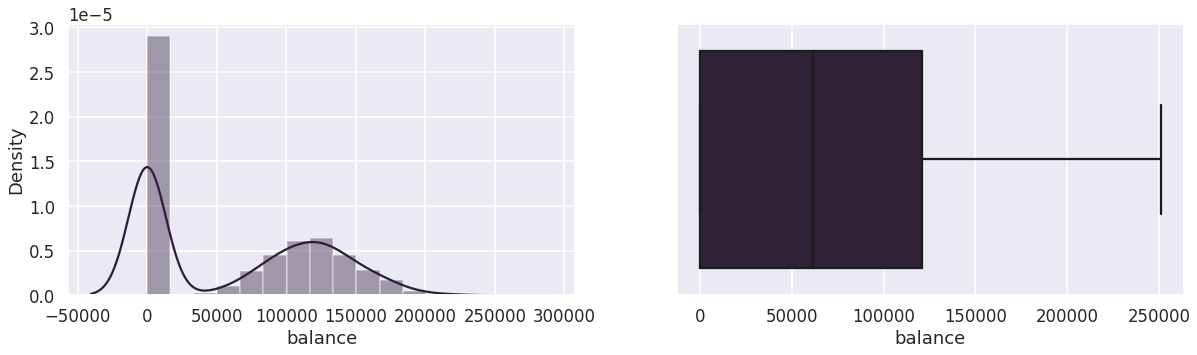

In [62]:
charts(rybinsk, 'balance', '')

**Промежуточный вывод:** Сохраняется основная тенденция. Наилучшие клиенты для банка: клиенты с 2-мя услугами/продуктами банка самый низкий отток - 7%. Средний возраст - 37 лет. Средний сконринг - 652. 
Наихудшие клиенты от 39 лет с 1 продукт 21% или 3-4 продуктами (отток - 78%, 100%).

#### Ярославль

In [63]:
yaroslavl = data[data['city'] == 'Ярославль']

In [64]:
yaroslavl.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,5014.0,1.573339e+07,71375.837573,15608450.00,15671341.75,15733506.00,1.579491e+07,15858396.00
score,5014.0,6.496683e+02,97.016799,350.00,582.00,653.00,7.170000e+02,850.00
age,5014.0,3.851177e+01,10.469459,18.00,31.00,37.00,4.300000e+01,92.00
objects,5014.0,5.004587e+00,2.888475,0.00,2.00,5.00,7.000000e+00,10.00
balance,5014.0,6.209264e+04,64133.565524,0.00,0.00,62153.50,1.214449e+05,238387.56
products,5014.0,1.530913e+00,0.570347,1.00,1.00,1.00,2.000000e+00,4.00
creditcard,5014.0,7.066215e-01,0.455356,0.00,0.00,1.00,1.000000e+00,1.00
loyalty,5014.0,5.167531e-01,0.499769,0.00,0.00,1.00,1.000000e+00,1.00
estimated_salary,5014.0,9.989918e+04,57336.289016,90.07,51399.19,99132.31,1.492954e+05,199929.17
churn,5014.0,1.615477e-01,0.368072,0.00,0.00,0.00,0.000000e+00,1.00


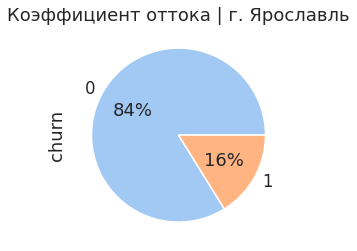

In [65]:
yaroslavl['churn'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Коэффициент оттока | г. Ярославль')
plt.show()

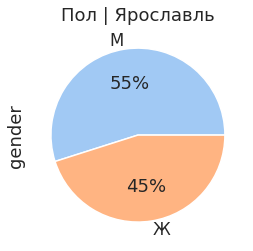

In [66]:
yaroslavl['gender'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Пол | Ярославль')
plt.show()

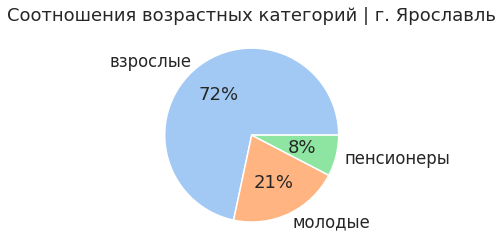

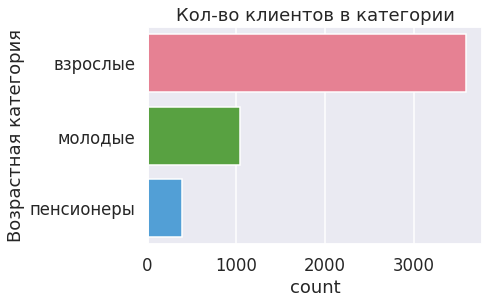

In [67]:
yaroslavl['age_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения возрастных категорий | г. Ярославль')
plt.ylabel('')
plt.show()
sns.countplot(y='age_category', data=yaroslavl, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Возрастная категория')
plt.show()

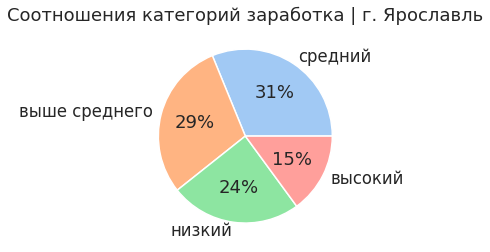

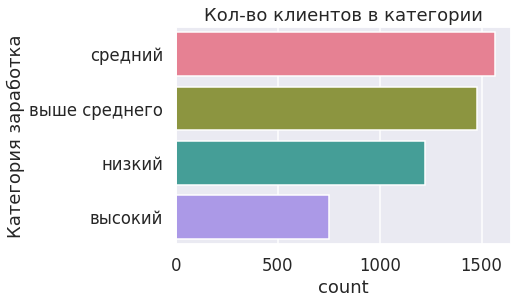

In [68]:
yaroslavl['income_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения категорий заработка | г. Ярославль')
plt.ylabel('')
plt.show()
sns.countplot(y='income_category', data=yaroslavl, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Категория заработка')
plt.show()

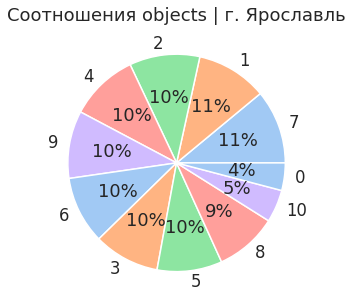

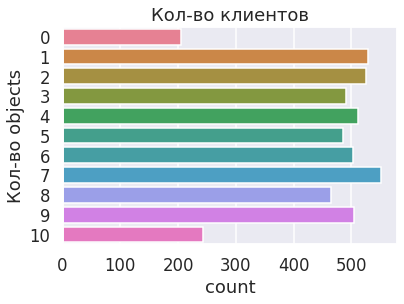

In [69]:
plt.figure(figsize=(12,5))
yaroslavl['objects'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения objects | г. Ярославль')
plt.ylabel('')
plt.show()
sns.countplot(y='objects', data=yaroslavl, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во objects')
plt.show()

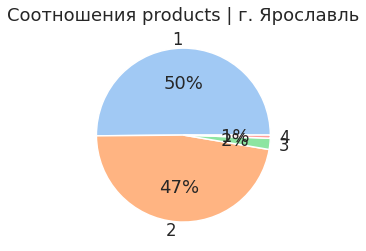

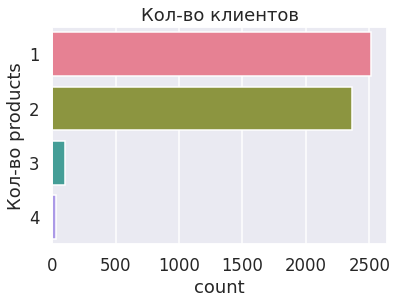

In [70]:
yaroslavl['products'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения products | г. Ярославль')
plt.ylabel('')
plt.show()
sns.countplot(y='products', data=yaroslavl, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во products')
plt.show()

In [71]:
yaroslavl.groupby('products').mean()

,userid,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
products,,,,,,,,,
1,1.573229e+07,647.989658,39.175418,4.962609,90977.877896,0.710024,0.501591,98760.372673,0.224344
2,1.573435e+07,651.518378,37.453739,5.032108,31828.097047,0.702577,0.536122,100748.059649,0.057034
3,1.573976e+07,643.615385,44.221154,5.125000,50071.822500,0.759615,0.423077,102831.108558,0.788462
4,1.572726e+07,665.896552,46.862069,5.965517,71362.731379,0.551724,0.586207,118821.490345,1.000000


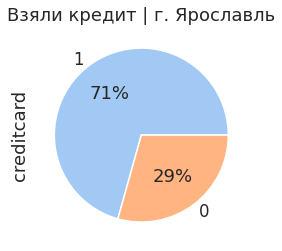

In [72]:
yaroslavl['creditcard'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Взяли кредит | г. Ярославль')
plt.show()

In [73]:
yaroslavl.groupby('churn').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573301e+07,651.162226,37.235966,5.005471,60339.275678,1.541389,0.707422,0.545433,99217.097331
1,1.573535e+07,641.914815,45.133333,5.000000,71192.795728,1.476543,0.702469,0.367901,103439.278296


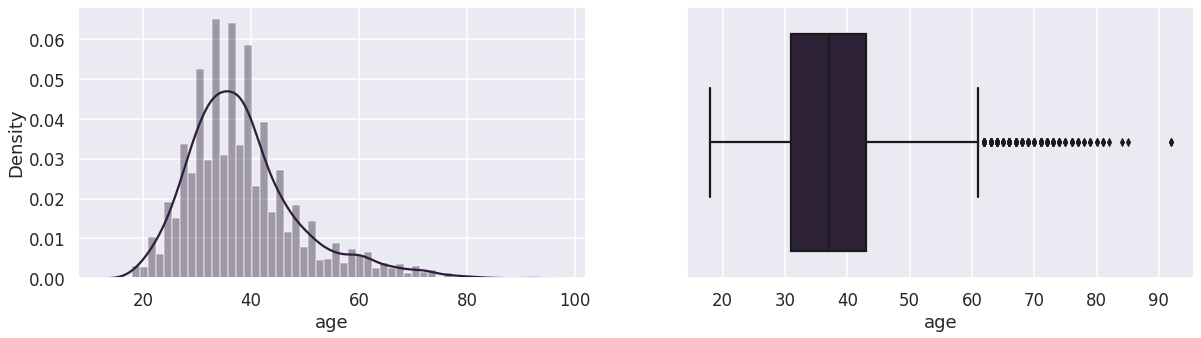

In [74]:
charts(yaroslavl, 'age', '')

**Промежуточные вывод:** Сохраняется основная тенденция. Наилучшие клиенты для банка: клиенты с 2-мя услугами/продуктами банка самый низкий отток - 5%. Средний возраст - 37 лет. Средний сконринг - 651. 
Наихудшие клиенты от 39 лет с 1 продукт 22% или 3-4 продуктами (отток - 78%, 100%).

#### Ростов Великий

In [75]:
rostov = data[data['city'] == 'Ростов Великий']

In [76]:
rostov.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,2509.0,1.573329e+07,73228.429284,15608515.00,15670131.00,15732622.00,15798467.00,15858392.00
score,2509.0,6.514536e+02,98.168937,350.00,584.00,651.00,722.00,850.00
age,2509.0,3.977162e+01,10.519143,18.00,32.00,38.00,45.00,84.00
objects,2509.0,5.009964e+00,2.935154,0.00,2.00,5.00,8.00,10.00
balance,2509.0,1.197301e+05,27022.006157,27288.43,102800.72,119703.10,137560.38,214346.96
products,2509.0,1.519729e+00,0.619420,1.00,1.00,1.00,2.00,4.00
creditcard,2509.0,7.138302e-01,0.452060,0.00,0.00,1.00,1.00,1.00
loyalty,2509.0,4.974093e-01,0.500093,0.00,0.00,0.00,1.00,1.00
estimated_salary,2509.0,1.011134e+05,58263.011501,11.58,51016.02,102397.22,151083.80,199970.74
churn,2509.0,3.244320e-01,0.468256,0.00,0.00,0.00,1.00,1.00


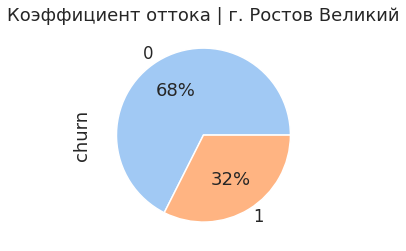

In [77]:
rostov['churn'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Коэффициент оттока | г. Ростов Великий')
plt.show()

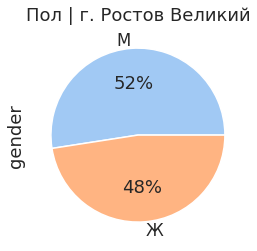

In [78]:
rostov['gender'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Пол | г. Ростов Великий')
plt.show()

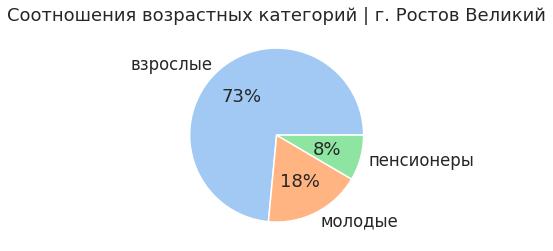

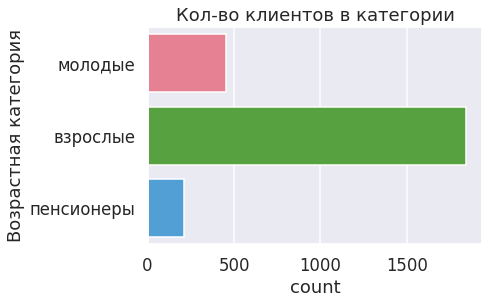

In [79]:
rostov['age_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения возрастных категорий | г. Ростов Великий')
plt.ylabel('')
plt.show()
sns.countplot(y='age_category', data=rostov, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Возрастная категория')
plt.show()

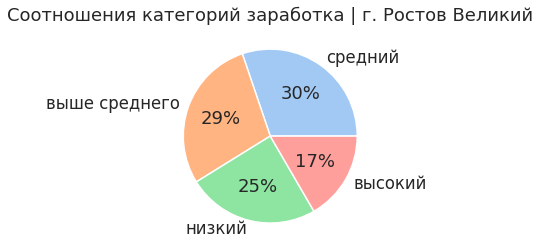

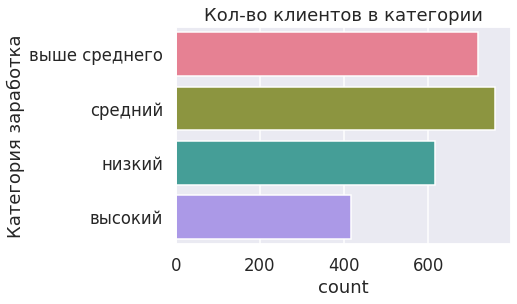

In [80]:
rostov['income_category'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения категорий заработка | г. Ростов Великий')
plt.ylabel('')
plt.show()
sns.countplot(y='income_category', data=rostov, palette="husl")
plt.title('Кол-во клиентов в категории')
plt.ylabel('Категория заработка')
plt.show()

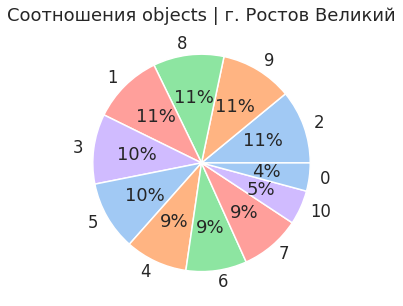

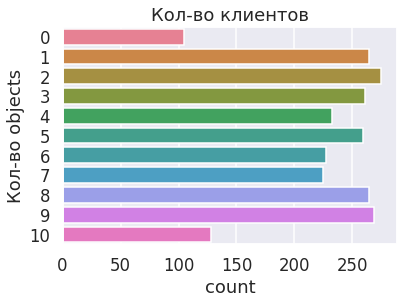

In [81]:
plt.figure(figsize=(12,5))
rostov['objects'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения objects | г. Ростов Великий')
plt.ylabel('')
plt.show()
sns.countplot(y='objects', data=rostov, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во objects')
plt.show()

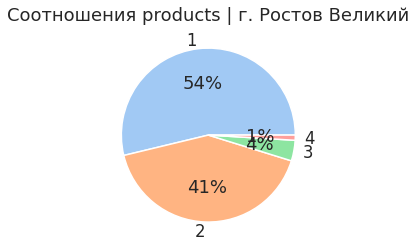

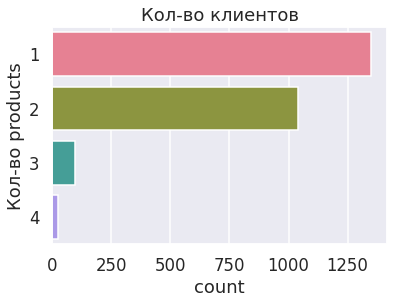

In [82]:
rostov['products'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения products | г. Ростов Великий')
plt.ylabel('')
plt.show()
sns.countplot(y='products', data=rostov, palette="husl")
plt.title('Кол-во клиентов')
plt.ylabel('Кол-во products')
plt.show()

In [83]:
rostov.groupby('products').mean()

,userid,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
products,,,,,,,,,
1,1.573196e+07,651.402520,40.572276,5.005189,119868.328139,0.705708,0.466271,101029.034136,0.428466
2,1.573432e+07,651.543269,38.267308,5.025000,119341.245038,0.720192,0.546154,100832.057606,0.121154
3,1.574546e+07,653.718750,43.656250,5.010417,121572.672396,0.750000,0.427083,106681.521667,0.895833
4,1.571482e+07,641.375000,44.416667,4.625000,121442.305417,0.750000,0.416667,95778.151250,1.000000


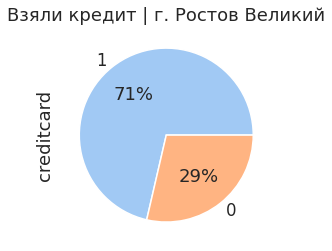

In [84]:
rostov['creditcard'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Взяли кредит | г. Ростов Великий')
plt.show()

In [85]:
rostov.groupby('churn').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573418e+07,653.261357,37.311504,5.011799,119427.106696,1.551032,0.716224,0.561652,102414.657876
1,1.573144e+07,647.689189,44.894349,5.006143,120361.075590,1.454545,0.708845,0.363636,98403.886450


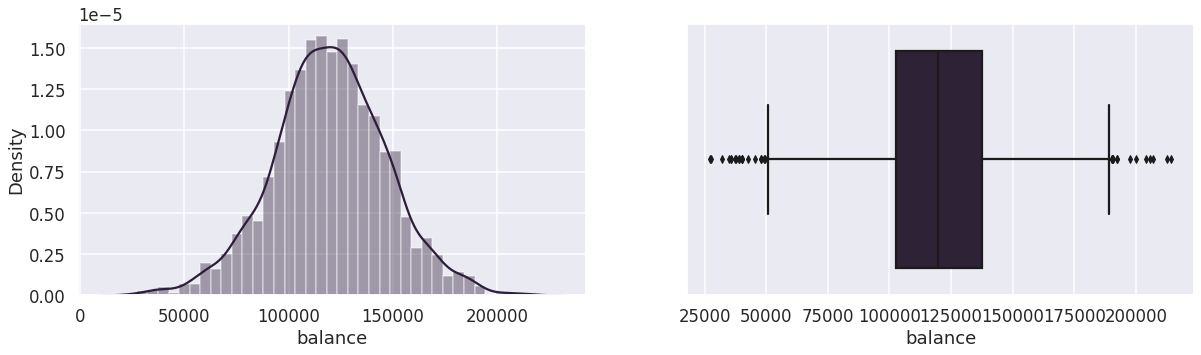

In [86]:
charts(rostov, 'balance', '')

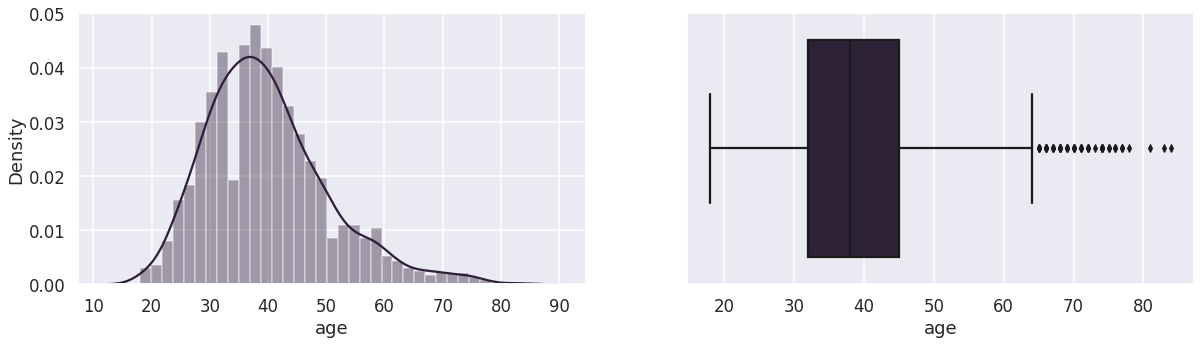

In [87]:
charts(rostov, 'age', '')

**Промежуточные выводы:** Сохраняется основная тенденция. Наилучшие клиенты для банка: клиенты с 2-мя услугами/продуктами банка самый низкий отток - 12%. Средний возраст - 37 лет. Средний сконринг - 653. 
Наихудшие клиенты от 39 лет с 1 продукт 42% или 3-4 продуктами (отток - 89%, 100%).
Видим, что Ростов Великий выделяется большим процентом оттока по сравнению с другими городами по всем категориям клиентов.

### Corr

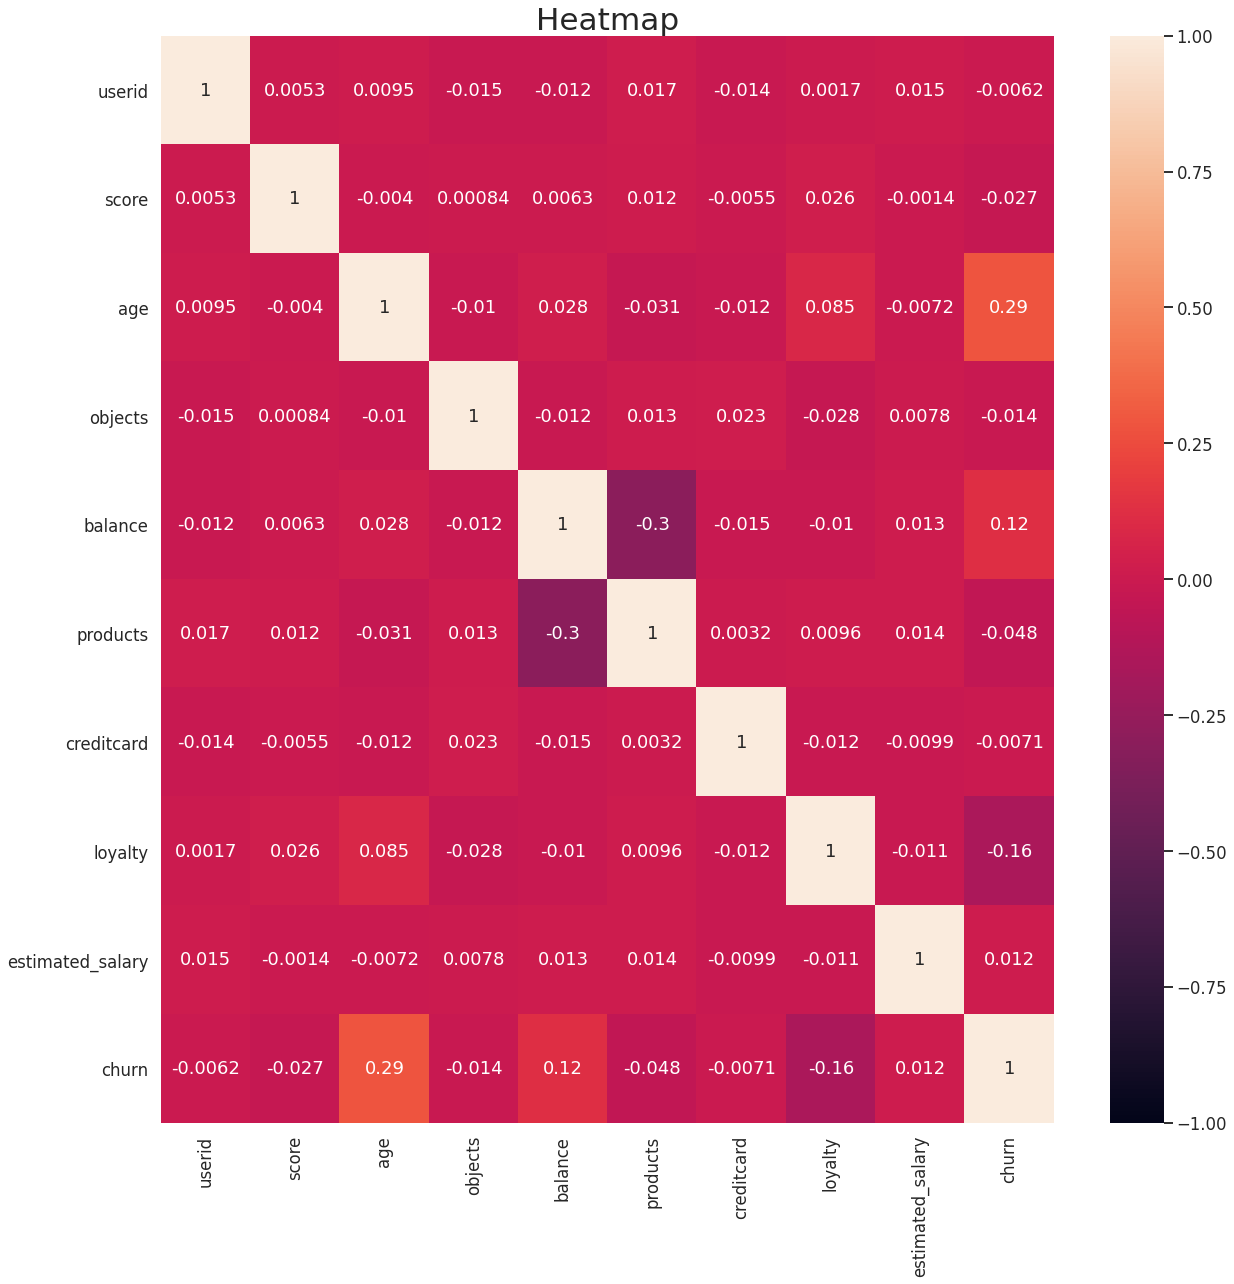

In [88]:
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Heatmap', fontsize='xx-large')
plt.show()

**Промежуточный вывод:** Имеется слабая корреляция у возраста и оттока (0.29).

In [89]:
corr = data.copy()

In [90]:
del corr['age_category'], corr['income_category'], corr['score_category']

In [91]:
corr = pd.get_dummies(corr)

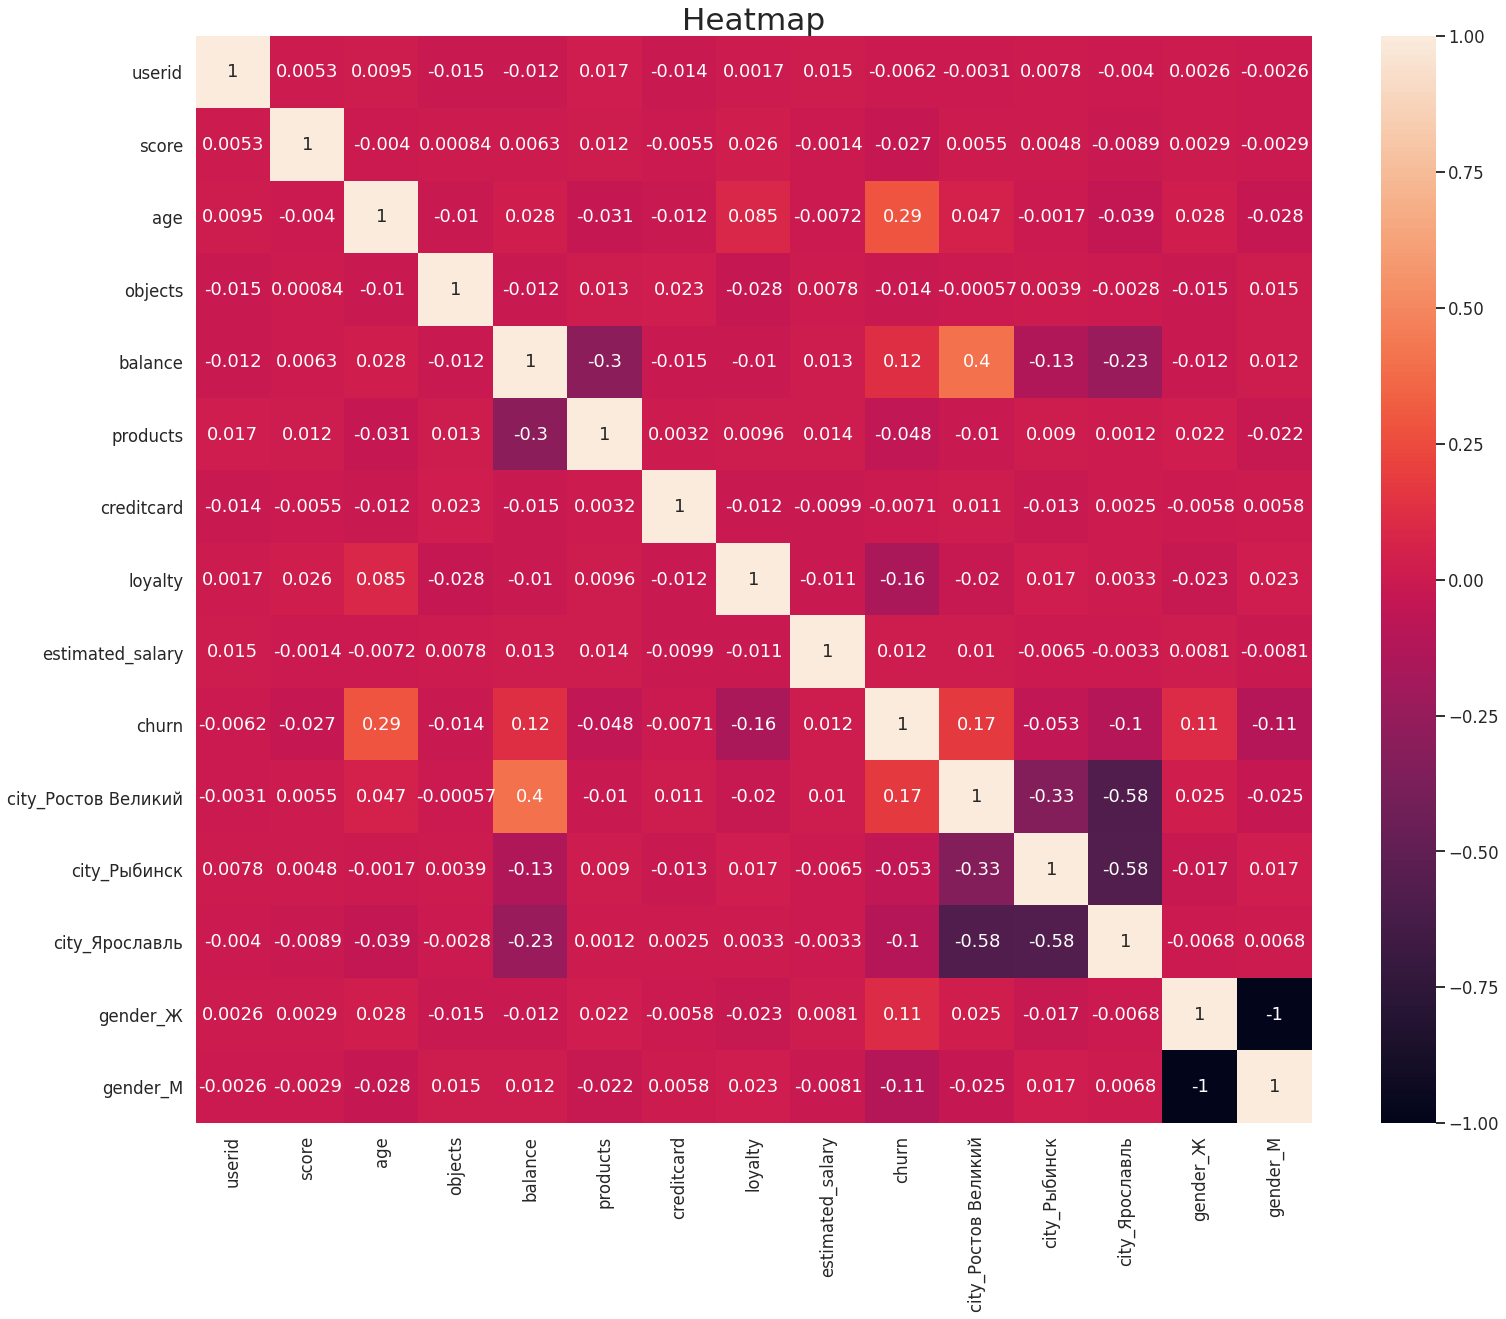

In [92]:
plt.figure(figsize=(25,20))
heatmap = sns.heatmap(corr.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Heatmap', fontsize='xx-large')
plt.show()

**Промежуточный вывод:** После проведения - OHE, видим, что имеется слабая корреляция у баланса и г. Ростова Великого (0.40).

### Выводы

По итогом анализа сформировались предположительные портреты желательных и нежелательных клиентов для банка:
- Нежелательные клиенты: М/Ж от 40 лет, имеющие скоринг ниже 650, пользующиеся 3-4 услугами.
- Желательные клиенты: М/Ж до 40 лет, имеющие скоринг выше 650, использующие 1-2 продукта.

Далее для подтверждения наших предположений проверим следующие статистические гипотезы - одинаковые или разные: доходы, скоринг, кол-во используемых услуг/продуктов и возрасте ушедших и оставшихся клиентов.

## Проверка гипотез

In [93]:
stay = data[data['churn'] == 0]
left = data[data['churn'] == 1]

**Гипотеза I**

Нулевая `гипотеза H₀`: «Различий дохода между теми клиентами, которые ушли и теми, которые остались — нет!»

Альтернативная `гипотеза H₁`: "Различия дохода между теми клиентами, которые ушли и теми, которые остались — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и доходы между теми клиентами, которые ушли и теми, которые остались - равны».

In [94]:
alpha = 0.05

print('Дисперсия оставшихся:', round(stay['estimated_salary'].var(), 1))
print('Дисперсия ушедших:', round(left['estimated_salary'].var(), 1))
print()

results = st.ttest_ind(stay['estimated_salary'], left['estimated_salary'])

print('p-value', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: между ушедшими и оставшимися доходы разные')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу: между ушедшими и оставшимися доходы равные')
    print('Статистической значимости — нет!')

Дисперсия оставшихся: 3295401414.9
Дисперсия ушедших: 3353848166.8

p-value 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу: между ушедшими и оставшимися доходы равные
Статистической значимости — нет!


**Гипотеза II**

Нулевая `гипотеза H₀`: «Различий между скорингом теми клиентами, которые ушли и теми, которые остались — нет!»

Альтернативная `гипотеза H₁`: "Различия между скорингом теми клиентами, которые ушли и теми, которые остались — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и скоринг между теми клиентами, которые ушли и теми, которые остались - равный».

In [95]:
print('Дисперсия оставшихся:', round(stay['score'].var(), 1))
print('Дисперсия ушедших:', round(left['score'].var(), 1))
print()

results = st.ttest_ind(stay['score'], left['score'])

print('p-value', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: между ушедшими и оставшимися скоринг разный')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу: между ушедшими и оставшимися скоринг равный')
    print('Статистической значимости — нет!')

Дисперсия оставшихся: 9149.7
Дисперсия ушедших: 10064.4

p-value 0.006738213892192373
Отвергаем нулевую гипотезу: между ушедшими и оставшимися скоринг разный
Статистическая значимость — есть!


**Гипотеза III**

Нулевая `гипотеза H₀`: «Различий между кол-вом используемых услуг теми клиентами, которые ушли и теми, которые остались — нет!»

Альтернативная `гипотеза H₁`: "Различия между кол-вом используемых услуг теми клиентами, которые ушли и теми, которые остались — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и кол-во используемых услуг между теми клиентами, которые ушли и теми, которые остались - равно».

In [96]:
print('Дисперсия оставшихся:', round(stay['products'].var(), 1))
print('Дисперсия ушедших:', round(left['products'].var(), 1))
print()

results = st.ttest_ind(stay['products'], left['products'])

print('p-value', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: между ушедшими и оставшимися кол-во используемых услуг разное')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу: между ушедшими и оставшимися кол-во используемых услуг равно')
    print('Статистической значимости — нет!')

Дисперсия оставшихся: 0.3
Дисперсия ушедших: 0.6

p-value 1.717333004804293e-06
Отвергаем нулевую гипотезу: между ушедшими и оставшимися кол-во используемых услуг разное
Статистическая значимость — есть!


**Гипотеза IV**

Нулевая `гипотеза H₀`: «Различия в возрате у клиентов, которые ушли и теми, которые остались — нет!»

Альтернативная `гипотеза H₁`: "Различия в возрасте у клиентов, которые ушли и теми, которые остались — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и возраст между клиентами, которые ушли и теми, которые остались - равен».

In [97]:
print('Дисперсия оставшихся:', round(stay['age'].var(), 1))
print('Дисперсия ушедших:', round(left['age'].var(), 1))
print()

results = st.ttest_ind(stay['age'], left['age'])

print('p-value', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: между ушедшими и оставшимися возраст разный')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу: между ушедшими и оставшимися возраст равный')
    print('Статистической значимости — нет!')

Дисперсия оставшихся: 102.5
Дисперсия ушедших: 95.3

p-value 1.2399313093427738e-186
Отвергаем нулевую гипотезу: между ушедшими и оставшимися возраст разный
Статистическая значимость — есть!


**Промежуточные выводы:** 

Проверили четыре гипотезы и подтвердили складывающуюся общую картину, что: 
- между ушедшими и оставшимися доходы равные, 
- между ушедшими и оставшимися скоринг разный,
- между ушедшими и оставшимися кол-во используемых услуг/продуктов разное,
- между ушедшими и оставшимися возраст разный.

## Подготовка данных к маш. обучению

In [98]:
df = data.copy()

In [99]:
del df['age_category'], df['income_category'], df['score_category']

In [100]:
df = df.set_index('userid')

df = pd.get_dummies(df, drop_first=True)

In [101]:
df.head()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Рыбинск,city_Ярославль,gender_М
userid,,,,,,,,,,,,
15677338,619,42,2,0.00,1,1,1,101348.88,1,0,1,0
15690047,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0
15744090,699,39,1,0.00,2,0,0,93826.63,0,0,1,0
15780624,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0


In [102]:
x = df.drop('churn', axis=1)
y = df['churn']

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=0)

print('Train shape:', x_train.shape)
print('Test shape:', x_test.shape)

Train shape: (8000, 11)
Test shape: (2000, 11)


In [104]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

**Промежуточные выводы:** Перевели категориальные признаки в численные. Определили значения признаков `x` и целевую переменную `y`. Разделили данные на обучающую и тестовую выборки в пропорции 80:20. Стандартизировали данные. 

## Обучение моделей

In [105]:
model_1 = RandomForestClassifier(random_state=0)
model_2 = DecisionTreeClassifier(random_state=0)

param_RF = {'n_estimators':[5,100],
             'max_depth':[1,20], 'min_samples_split': [2, 3]}
param_DT= {'max_depth':[1,10], 'splitter':('best','random'), 'min_samples_split':np.arange(2,10)}

RF = GridSearchCV(model_1,param_grid = param_RF, cv=5)
DT = GridSearchCV(model_2,param_grid = param_DT, cv=5)

### Random Forest

In [106]:
%%time
#Random Forest
start_1 = time.time()
RF.fit(x_train_st, y_train)
end_1 = time.time()
fit_RF = end_1 - start_1

start_2 = time.time()
prediction_RF = RF.predict(x_test_st)
end_2 = time.time()
pred_RF = end_2 - start_2

pre_proba_RF = RF.predict_proba(x_test_st)[:,1]

roc_auc_RF_proba = roc_auc_score(y_test, pre_proba_RF)
accuracy_RF = accuracy_score(y_test, prediction_RF)
precision_RF = precision_score(y_test, prediction_RF)
recall_RF = recall_score(y_test, prediction_RF)


print('\n========================================================')
print('Random Forest')
print('========================================================')
print('ROC-AUC:', round(roc_auc_RF_proba, 4) )
print('Accuracy:', round(accuracy_RF, 4))
print('Precision:', round(precision_RF, 4))
print('Recall:', round(recall_RF, 4))
print('Время обучения:', round(fit_RF,4), 'vs', 'Время предсказания', round(pred_RF,4))
print()
print('Наилучшие гиперпараметры:',RF.best_params_)
print()


Random Forest
ROC-AUC: 0.8623
Accuracy: 0.865
Precision: 0.7509
Recall: 0.4988
Время обучения: 10.6952 vs Время предсказания 0.0527

Наилучшие гиперпараметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

CPU times: user 10.7 s, sys: 71 ms, total: 10.8 s
Wall time: 10.8 s


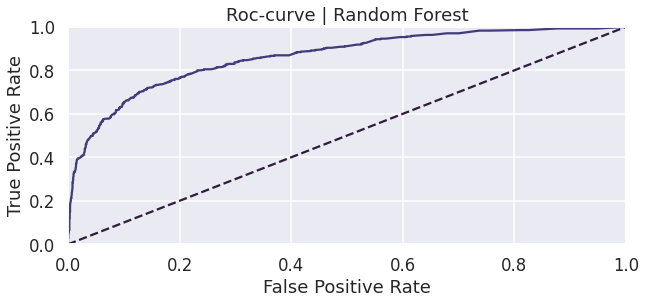

AUC-ROC: 0.8623


In [107]:
fpr, tpr, thresholds = roc_curve(y_test, pre_proba_RF)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | Random Forest')
plt.show()

print('AUC-ROC:', round(roc_auc_RF_proba, 4))

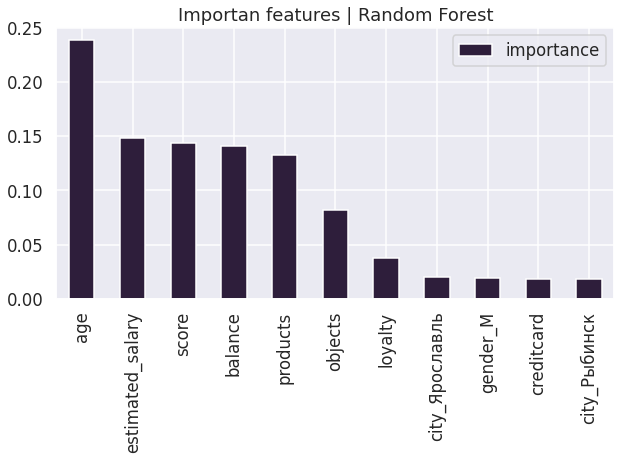

In [108]:
imp = pd.DataFrame(RF.best_estimator_.feature_importances_, index = x_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | Random Forest')

### DecisionTreeClassifier

In [109]:
%%time
#DecisionTree
start_1 = time.time()
DT.fit(x_train_st, y_train)
end_1 = time.time()
fit_DT = end_1 - start_1

start_2 = time.time()
prediction_DT = DT.predict(x_test_st)
end_2 = time.time()
pred_DT = end_2 - start_2

pre_proba_DT = DT.predict_proba(x_test_st)[:,1]

roc_auc_DT_proba = roc_auc_score(y_test, pre_proba_DT)
accuracy_DT = accuracy_score(y_test, prediction_DT)
precision_DT = precision_score(y_test, prediction_DT)
recall_DT = recall_score(y_test, prediction_DT)


print('\n========================================================')
print('Decision Tree')
print('========================================================')
print('ROC-AUC:', round(roc_auc_DT_proba, 4) )
print('Accuracy:', round(accuracy_DT, 4))
print('Precision:', round(precision_DT, 4))
print('Recall:', round(recall_DT, 4))
print('Время обучения:', round(fit_DT,4), 'vs', 'Время предсказания', round(pred_DT,4))
print()
print('Наилучшие гиперпараметры:',DT.best_params_)
print()


Decision Tree
ROC-AUC: 0.8206
Accuracy: 0.8495
Precision: 0.6733
Recall: 0.4988
Время обучения: 1.619 vs Время предсказания 0.0006

Наилучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 4, 'splitter': 'random'}

CPU times: user 1.61 s, sys: 15.7 ms, total: 1.62 s
Wall time: 1.63 s


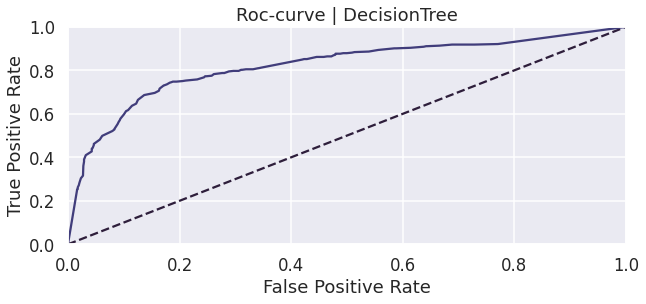

AUC-ROC: 0.8206


In [110]:
fpr, tpr, thresholds = roc_curve(y_test, pre_proba_DT)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | DecisionTree')
plt.show()

print('AUC-ROC:', round(roc_auc_DT_proba, 4))

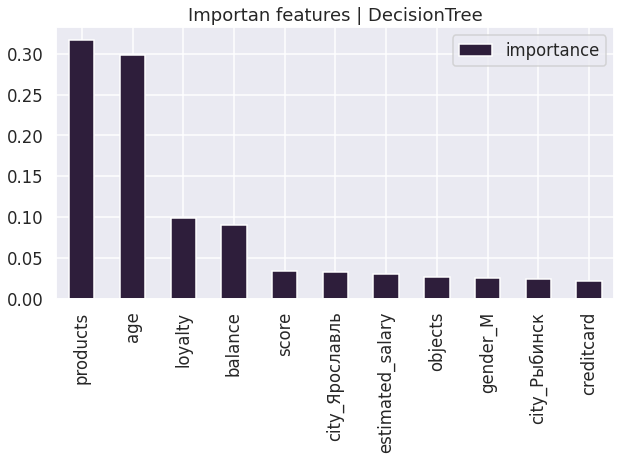

In [111]:
imp = pd.DataFrame(DT.best_estimator_.feature_importances_, index = x_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | DecisionTree')

### CatBoost

In [112]:
param = {'learning_rate': [0.1, 0.3]}

model = CatBoostClassifier(random_state=0, iterations=100)

cat = GridSearchCV(model, param_grid = param, cv=5)

In [113]:
%%time
start_1 = time.time()
cat.fit(x_train_st, y_train,eval_set=[(x_test_st, y_test),], verbose = 100)
end_1 = time.time()
fit_cat = end_1 - start_1

start_2 = time.time()
prediction_cat = cat.predict(x_test_st)
end_2 = time.time()
pred_cat = end_2 - start_2

pre_proba_cat = cat.predict_proba(x_test_st)[:,1]

roc_auc_cat_proba = roc_auc_score(y_test, pre_proba_cat)
accuracy_cat = accuracy_score(y_test, prediction_cat)
precision_cat = precision_score(y_test, prediction_cat)
recall_cat = recall_score(y_test, prediction_cat)
   
print("\n========================================================")
print("CatBoost" )
print("========================================================")
print('Roc-AUC:', round(roc_auc_cat_proba, 4))
print('Accuracy:', round(accuracy_cat, 4))
print('Precision:', round(precision_cat, 4))
print('Recall:', round(recall_cat, 4))
print('Время обучения:', round(fit_cat,4), 'vs', 'Время предсказания:', round(pred_cat,4))
print('Наилучшие гиперпараметры:', cat.best_params_)
print()

0:	learn: 0.6457465	test: 0.6466692	best: 0.6466692 (0)	total: 48.8ms	remaining: 4.83s
99:	learn: 0.3149956	test: 0.3260913	best: 0.3260913 (99)	total: 242ms	remaining: 0us

bestTest = 0.3260912736
bestIteration = 99

0:	learn: 0.6449004	test: 0.6448176	best: 0.6448176 (0)	total: 2.88ms	remaining: 285ms
99:	learn: 0.3123922	test: 0.3249007	best: 0.3249007 (99)	total: 205ms	remaining: 0us

bestTest = 0.3249007174
bestIteration = 99

0:	learn: 0.6441635	test: 0.6443700	best: 0.6443700 (0)	total: 2.13ms	remaining: 210ms
99:	learn: 0.3111059	test: 0.3245179	best: 0.3245179 (99)	total: 202ms	remaining: 0us

bestTest = 0.3245179261
bestIteration = 99

0:	learn: 0.6440826	test: 0.6443602	best: 0.6443602 (0)	total: 1.83ms	remaining: 181ms
99:	learn: 0.3106895	test: 0.3229948	best: 0.3225482 (94)	total: 215ms	remaining: 0us

bestTest = 0.322548214
bestIteration = 94

Shrink model to first 95 iterations.
0:	learn: 0.6444650	test: 0.6443152	best: 0.6443152 (0)	total: 3.59ms	remaining: 356ms
99:	l

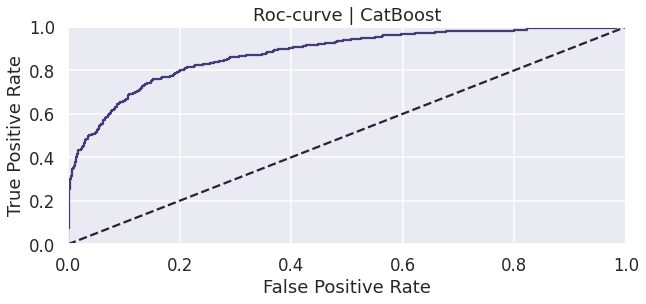

AUC-ROC: 0.8775


In [114]:
fpr, tpr, thresholds = roc_curve(y_test, pre_proba_cat)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | CatBoost')
plt.show()

print('AUC-ROC:', round(roc_auc_cat_proba, 4))

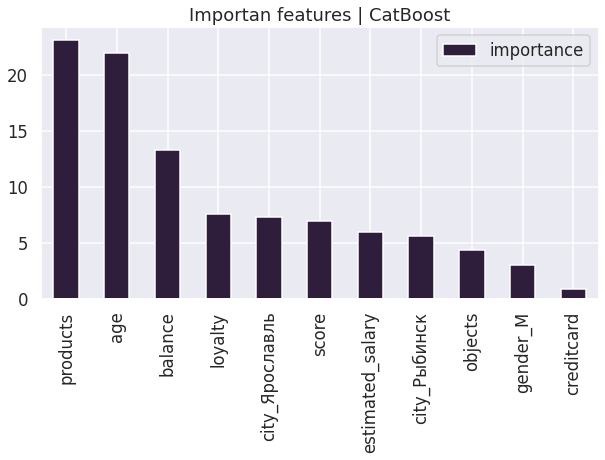

In [115]:
imp = pd.DataFrame(cat.best_estimator_.feature_importances_, index = x_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | CatBoost')

**Промежуточный вывод:** Обучили 3 модели и визуализировали важность признаков для каждой из модели. Видим, что каждая из моделей выделяет признак - возраст, а также две (Decision Tree, CatBoost) ставят на первое место признак - кол-во продуктов, используемых клиентом. Это также подтверждает, наши предположения.

## Кластеризация

In [116]:
cluster = data.copy()

In [117]:
del cluster['age_category'], cluster['income_category'], cluster['score_category']

In [118]:
cluster = pd.get_dummies(cluster)

cluster.head()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,15677338,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0


In [119]:
x_sc = scaler.fit_transform(cluster.drop(columns=['userid', 'churn']))
x_sc[:2]

array([[-0.32622142,  0.29351742, -1.04175968, -1.22584767, -0.91158349,
         0.64609167,  0.97024255,  0.02188649, -0.57873591, -0.57380915,
         0.99720391,  1.09598752, -1.09598752],
       [-0.44003595,  0.19816383, -1.38753759,  0.11735002, -0.91158349,
        -1.54776799,  0.97024255,  0.21653375, -0.57873591,  1.74273971,
        -1.00280393,  1.09598752, -1.09598752]])

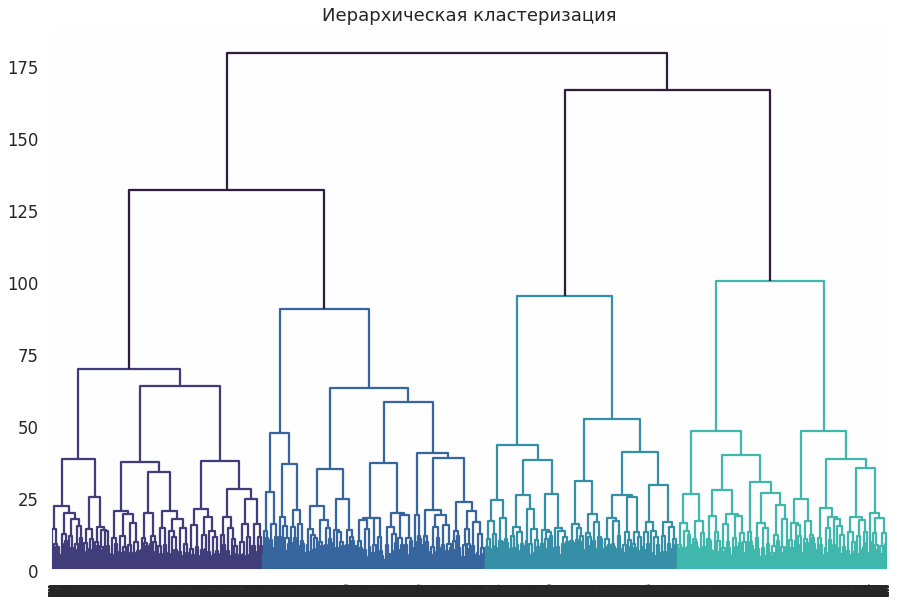

In [120]:
linked = linkage(x_sc, method='ward')

plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Для кластера=2, Метрика силуэта = 0.15563041201762795
Для кластера=3, Метрика силуэта = 0.18799835589775052
Для кластера=4, Метрика силуэта = 0.17129053385015328
Для кластера=5, Метрика силуэта = 0.18191099370365169
Для кластера=6, Метрика силуэта = 0.2009844249394699
Для кластера=7, Метрика силуэта = 0.17791478863612184


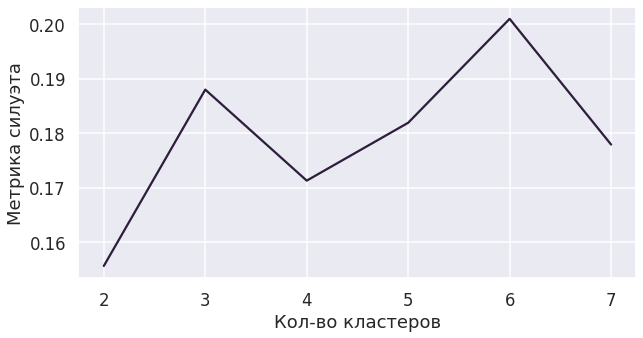

Оптимальное кол-во кластеров: 6


In [121]:
k_clusters = []
silhouette_coeff = []

for n_cluster in range(2,8):
    km = KMeans(n_clusters = n_cluster, random_state=0)
    label = km.fit_predict(x_sc)
    sil_coeff = silhouette_score(x_sc, label)
    print("Для кластера={}, Метрика силуэта = {}".format(n_cluster, sil_coeff))
    silhouette_coeff.append(sil_coeff)
    k_clusters.append(n_cluster)

plt.figure(figsize=(10,5))
plt.plot(k_clusters, silhouette_coeff)
plt.ylabel('Метрика силуэта'), plt.xlabel('Кол-во кластеров')
plt.show()

sil_best = max(silhouette_coeff)
k_best_index = silhouette_coeff.index(sil_best)
k_best = k_clusters[k_best_index]
print("Оптимальное кол-во кластеров:", k_best)

In [122]:
km = KMeans(n_clusters=6, random_state=0)
labels = km.fit_predict(x_sc)

cluster['cluster'] = labels
cluster.head()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М,cluster
0,15677338,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0,1
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0,4
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0,1
3,15744090,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0,1
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0,4


In [123]:
cluster.groupby('cluster').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
cluster,,,,,,,,,,,,,,,
0,1.573521e+07,649.966565,39.424772,5.050152,120259.668222,1.527356,0.720365,0.523556,99905.033959,0.278116,1,0,0,0,1
1,1.573504e+07,649.185759,38.773994,4.950022,60322.670159,1.547545,0.697921,0.513932,99564.252755,0.203450,0,0,1,1,0
2,1.573203e+07,650.064657,38.296404,5.049401,63546.284875,1.517254,0.713767,0.519070,100174.252495,0.127134,0,0,1,0,1
3,1.573480e+07,650.992075,38.649135,5.057637,63352.833746,1.512968,0.684438,0.539625,98425.687680,0.131124,0,1,0,0,1
4,1.573446e+07,651.769513,39.199265,5.000000,59862.092534,1.573003,0.707989,0.516988,100734.107475,0.212121,0,1,0,1,0
5,1.573117e+07,653.093881,40.154233,4.965633,119145.966471,1.511316,0.706622,0.468567,102446.424124,0.375524,1,0,0,1,0


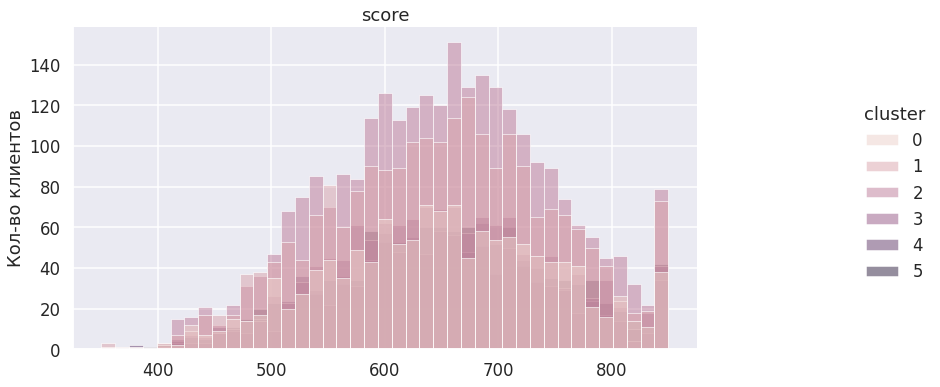

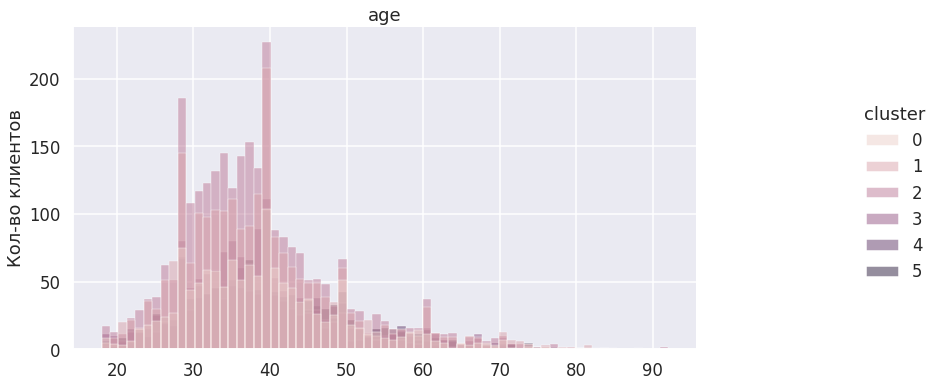

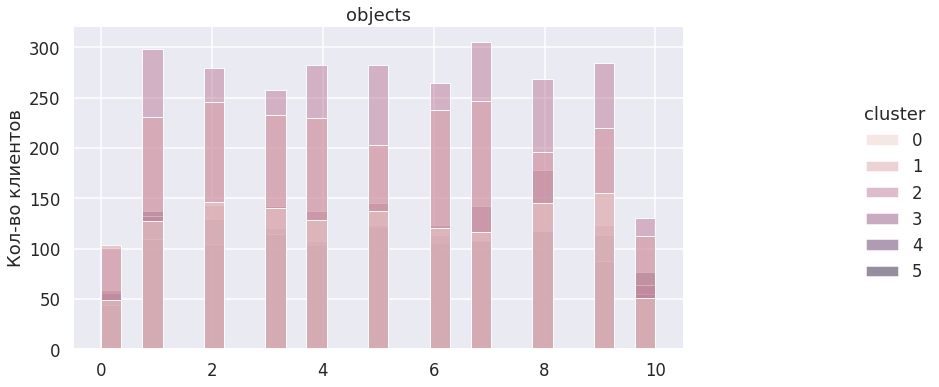

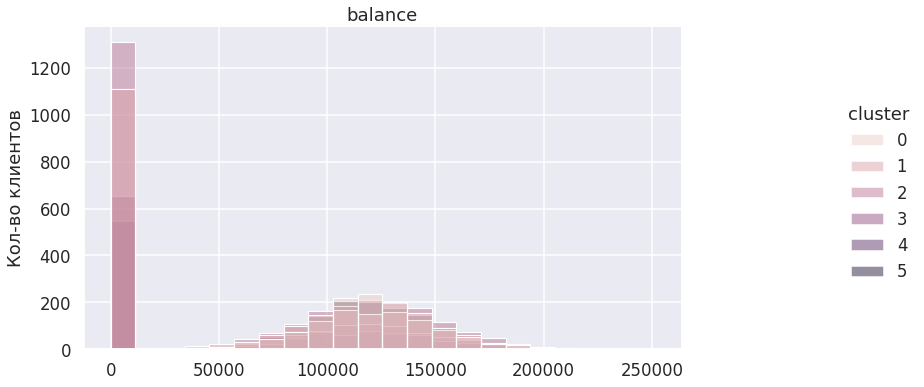

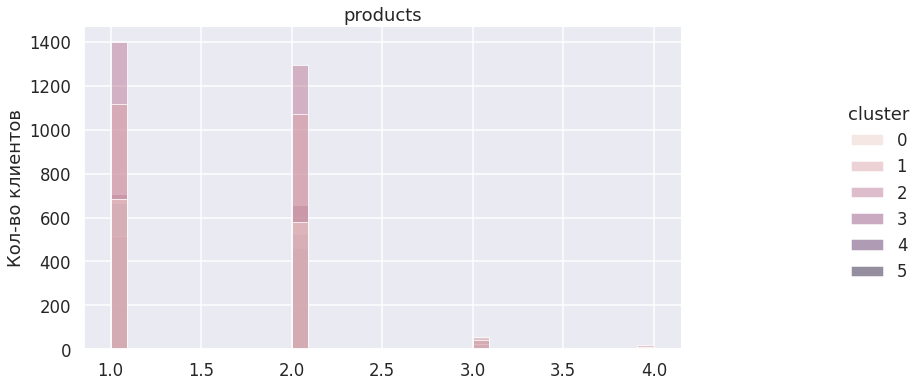

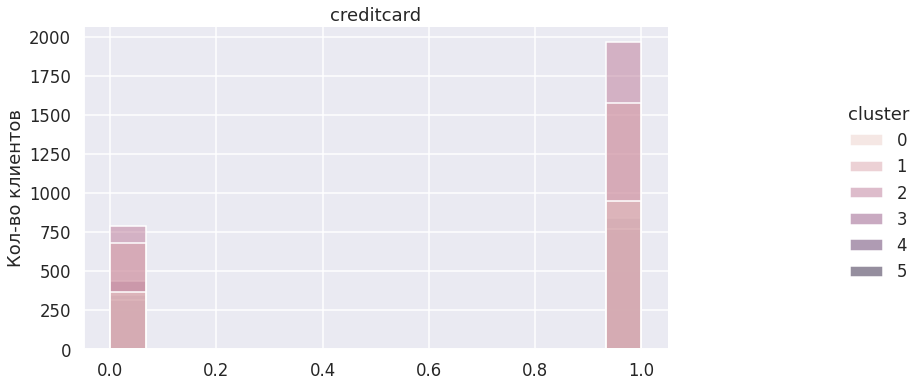

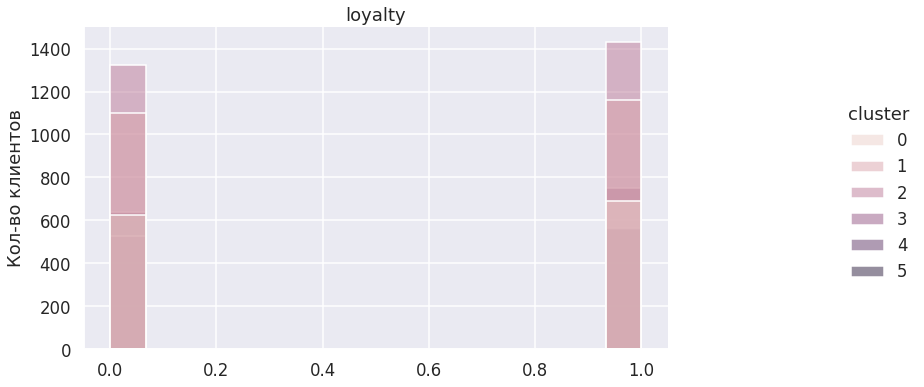

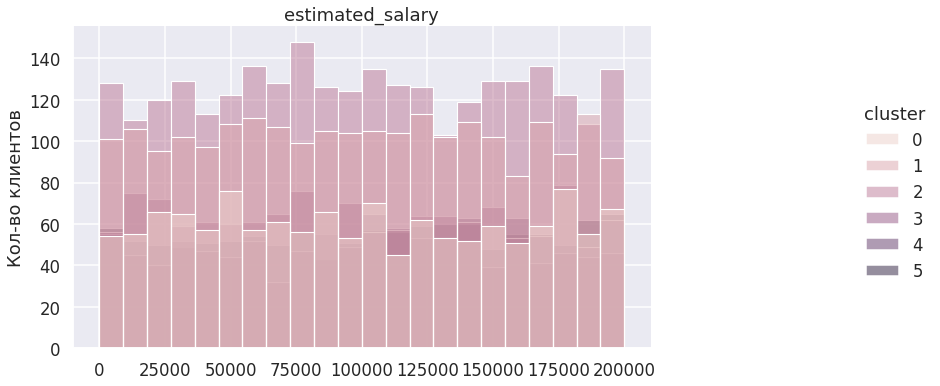

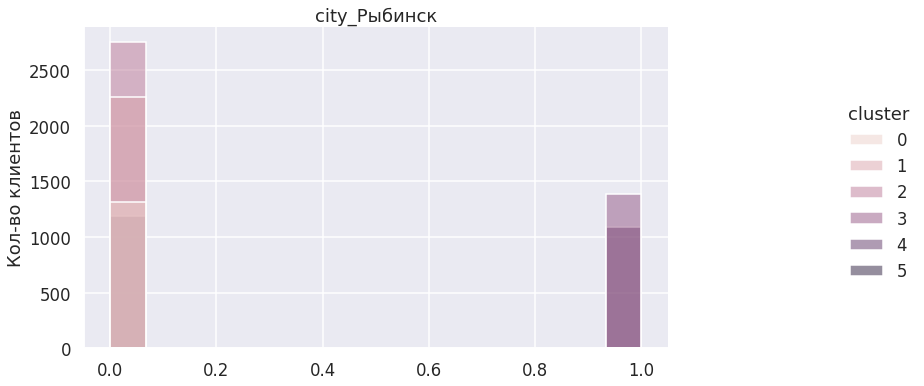

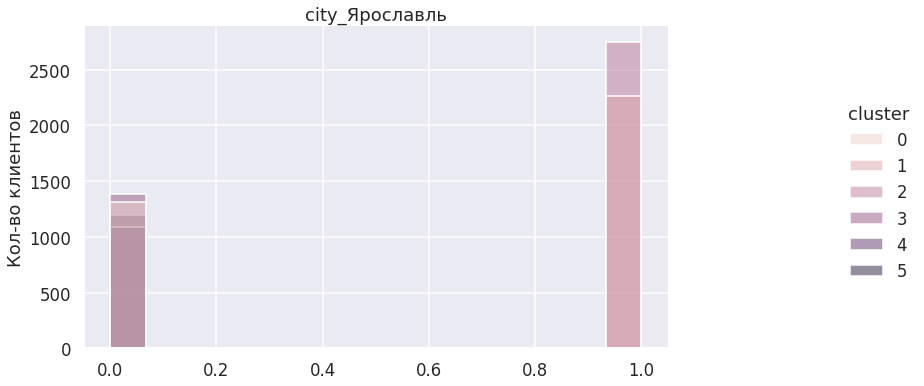

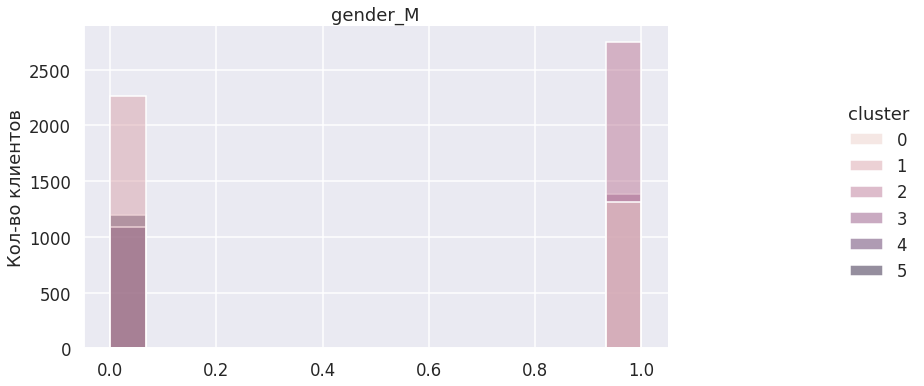

In [124]:
for i in x:
    dis = sns.displot(cluster, x=cluster[i], hue='cluster', kind='hist' )
    plt.title(i)
    plt.ylabel('Кол-во клиентов')
    plt.xlabel('')
    dis.fig.set_figwidth(15)
    dis.fig.set_figheight(6)
    dis.fig.patch.set_linewidth(5)

**Промежуточные выводы:**

Мужчины - 3 кластера
- Живущие в Ростове Великом, процент оттока 27%, средний возраст 39, скоринг 649
- Живущие в Ярославле, процент оттока 12%, средний возраст 38, средний скоринг 650
- Живущие в Рыбинске, процент оттока 13%, средний возраст 38, скоринг 650

Женщины - 3 кластера
- Живущие в Ярославле, процент оттока 20%, средний возраст 38, скоринг 649,
- Живущие в Рыбинске, процент оттока 21%, средний возраст 39, скоринг 651
- Живущие в Ростове Великом, процент оттока 37%, средний возраст 40, скоринг 653


Итак, картина получилась реалистичная, удалось выявить 6 кластеров, из которых видно, что наши сформированные портреты верны. Можно теперь окончательно сформировать портрет и добавить, что мужчины менее склонны к оттоку, чем женщины.

- Нежелательные клиенты: Женщины от 40 лет, имеющие скоринг ниже 650, пользующиеся 3-4 услугами.
- Желательные клиенты: Мужчины до 40 лет, имеющие скоринг выше 650, использующие 1-2 продукта.

## Выводы

Итак, передними стояла задача проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

После исследовательского анализа, проверок статистических гипотез, обучения алгоритмов на данный и проведения кластеризации удалось выявить следующее:

- Наиболее проблемный город для банка Ростов Великий, у него, примерно, на 15% отток больше в сравнении с другими городами (как у мужчин, так и у женщин). 
- Большинство 97% пользуется 1-2 услугами/продуктами банка
- Клиенты, которые склонны уходить из банка, те которые пользуются 3-4 услугами банка (от 80% до 100% оттока), далее клиенты, которые используют только одну услугу/продукт (27% оттока).
- Самый низкий отток у клиентов, которые пользуются 2 продуктами/услугами банка (7% оттока).
- У стабильных клиентов скоринг в среднем выше, чем у группы оттока.
- Женщины больше склонны к оттоку, не смотря на то, что мужчин на 10% больше в данной выборке.
- 60% клиентов имеют заработную плату от 50 тыс. до 170 тыс.
- Больше всех подвержены оттоку более возрастные клиенты.

Проверка статистических гипотез подтвердила сладыюващуюся картину: 
- между ушедшими и оставшимися доходы равные, 
- между ушедшими и оставшимися скоринг разный,
- между ушедшими и оставшимися кол-во используемых услуг разное,
- между ушедшими и оставшимися возраст разный.


Также, мы обучили 3 модели и визуализировали важность признаков для каждой из модели. Видим, что каждая из моделей выделяет признак - возраст, а также две (Decision Tree, CatBoost) ставят на первое место признак - кол-во продуктов, используемых клиентом.

После проведения кластеризации удалось выявить 6 кластеров, подтверждающие наше исследования, что возрастные клиенты, в частности женщины, более склоны к оттоку, а самый проблемный город это Ростов Великий.

Итак, можно сформировать следующие портреты:
- Склонные к оттоку клиенты: Женщины от 40 лет, имеющие скоринг ниже 650, пользующиеся 3-4 услугами.
- Не склонные к оттоку клиенты: Мужчины до 40 лет, имеющие скоринг выше 650, использующие 1-2 продукта.

**Сегментирование клиентов:**

**1-я группа** - клиенты проживающие в г.Ростов Великий. Коэффициент оттока - 32%. Средний возраст проживающих 40 лет. Женщины в среднем чуть старше мужчин. Средний баланс на счёте 120 тыс. 95% клиентов пользуются 1-2 услугами банка, 4% - 3 услугами и 1% - 4 услугами. Мужчины в среднем чуть больше склонны брать кредиты - 72%, чем женщины - 70%. Женщины в данном городе в среднем имеют выше скоринг (653), чем у мужчин (649). Также, женщины больше склонны к оттоку, чем мужчины, коэффициент оттока у женщин составляет - 37%, а мужчин - 27%.

Рекомендации:

- Провести анализ качества предоставляемых услуг и работу продуктов и, по возможности, адоптировать их под более возрастную группу. Тем самым снизить процент оттока возрастных клиентов, так как они имеют явно больше сбережений, чем молодые клиенты.
- В данном городе, всего 41% пользуются двумя услугами, это самый низкий показатель по городам, поэтому стоит активнее предлагать клиентам использующих одну услугу, воспользоваться 2-й. Может, на более выгодных условиях, раз они до сих пор пользуются одной и не используют вторую.
- Также, стоит провести проблемные интервью с клиентами, которые пользуются 3-4 услугами/продуктами банка, чтобы в дальнейшем провести акции по удержанию пользователей̆ старших лет,  в частности, женщин. 


**2-я группа** - клиенты проживающие в г.Рыбинск. Коэффициент оттока - 17%. Средний возраст проживающих 39 лет. Женщины в среднем чуть старше мужчин. Средний баланс на счёте 61 тыс. На средний баланс влияет нулевой остаток. Почти у половины (48%) клиентов имеются нулевой остаток по счету.  97% клиентов пользуются 1-2 услугами банка, 3% - 3 услугами, а 4 услугами пользуются всего 7 человек. Мужчины в среднем чуть менее склонны брать кредиты - 68%, чем женщины - 70%. Женщины в данном городе в среднем имеют выше скоринг (651),чем у мужчин (650). Также, женщины больше склонны к оттоку, чем мужчины, коэффициент оттока у женщин составляет - 21%, а мужчин - 13%.

Рекомендации:

- Для борьбы с нулевым балансом, добавить или предложить более выгодный процент на ежемесячный остаток по счету, чтобы клиент был заинтересован оставлять средства на карте данного банка на длительное время или хранение.
- Провести анализ качества предоставляемых услуг и работу продуктов и, по возможности, адоптировать их под более возрастную группу. Тем самым снизить процент оттока возрастных клиентов, так как они имеют явно больше сбережений, чем молодые клиенты.
- Провести проблемные интервью с клиентами, которые пользуются 3-4 услугами/продуктами банка, чтобы в дальнейшем провести акции по удержанию пользователей̆ старших лет,  в частности, женщин. 
- В данном городе, распределим клиентов использующих 1 или 2 продукта практически равно, но так как у клиентов с 2 услугами отток самый низкий, необходимо активнее предлагать клиентам использующих одну услугу, воспользоваться 2-й. Например, предоставлять обширный и универсальный контент о ключевых функциональных преимуществах продуктов банка и предлагать регулярные обновления новостей, такие как объявления о сделках, специальных предложениях или предстоящих обновлениях.



**3-я группа** - клиенты проживающие в г.Ярославль. Коэффициент оттока - 16%. Средний возраст проживающих 38 лет. Женщины в среднем чуть старше мужчин. Средний баланс на счёте 62 тыс. На средний баланс влияет нулевой остаток. Почти у половины (48%) клиентов имеются нулевой остаток по счету.  97% клиентов пользуются 1-2 услугами банка, 3% - 3 услугами и 1% - 4 услугами. Женщины в данном городе в среднем имеют ниже скоринг (649), чем у мужчин (650). Женщины больше склонны к оттоку, чем мужчины, коэффициент оттока у женщин составляет - 20%, а мужчин - 12%.

Рекомендации:

- Для борьбы с нулевым балансом, добавить или предложить более выгодный процент на ежемесячный остаток по счету (кеш бек системы), чтобы клиент был заинтересован оставлять средства на карте данного банка на длительное время или хранение.
- Провести анализ качества предоставляемых услуг и работу продуктов и, по возможности, адоптировать их под более возрастную группу. Тем самым снизить процент оттока возрастных клиентов, так как они имеют явно больше сбережений, чем молодые клиенты.
- Провести проблемные интервью с клиентами, которые пользуются 3-4 услугами/продуктами банка, чтобы в дальнейшем провести акции по удержанию пользователей̆ старших лет,  в частности, женщин. Как вариант, предложить обучение тому, как использовать эти продукты/услуги с максимальной прибылью для клиента.
- В данном городе, распределим клиентов использующих 1 или 2 продукта практически равно, но все же в пользу 1 продукта, а так как у клиентов с 2 услугами отток самый низкий, необходимо активнее предлагать клиентам использующих одну услугу, воспользоваться 2-й. Например, предоставлять обширный и универсальный контент о ключевых функциональных преимуществах продуктов банка и предлагать регулярные обновления новостей, такие как объявления о сделках, специальных предложениях или предстоящих обновлениях.